In [162]:
import numpy as np

from repath.utils.paths import project_root

experiment_name = "bloodmucus_sigma0_nn_sampsize"
experiment_root = project_root() / "experiments" / experiment_name

In [5]:
samples_in = np.genfromtxt(experiment_root / 'samples.csv', delimiter=',')

In [7]:
samples_in.shape

(3585129, 73)

In [15]:
samples1 = samples_in[samples_in[:, 0] == 1, 1:]
samples2 = samples_in[samples_in[:, 0] == 2, 1:]
samples3 = samples_in[samples_in[:, 0] == 3, 1:]
samples4 = samples_in[samples_in[:, 0] == 4, 1:]
print(samples1.shape, samples2.shape, samples3.shape, samples4.shape)

(918933, 72) (951357, 72) (821350, 72) (893489, 72)


In [18]:
sampsize = 100000

subsamples1 = samples1[np.random.choice(range(samples1.shape[0]), sampsize, replace=False), :]
subsamples2 = samples2[np.random.choice(range(samples2.shape[0]), sampsize, replace=False), :]
subsamples3 = samples3[np.random.choice(range(samples3.shape[0]), sampsize, replace=False), :]
subsamples4 = samples4[np.random.choice(range(samples4.shape[0]), sampsize, replace=False), :]
feats_sample = np.vstack((subsamples1, subsamples2, subsamples3, subsamples4))
feats_sample.shape

(400000, 72)

In [20]:
label_sample = np.vstack((np.repeat(1,subsamples1.shape[0]),np.repeat(2,subsamples2.shape[0]),np.repeat(3,subsamples3.shape[0]),np.repeat(4,subsamples4.shape[0])))

In [22]:
from sklearn.neural_network import MLPClassifier

clf1 = MLPClassifier(hidden_layer_sizes=[50, 50, 50], max_iter=500, verbose=True)
clf1.fit(feats_sample, label_sample.ravel())

Iteration 1, loss = 0.78354082
Iteration 2, loss = 0.69934088
Iteration 3, loss = 0.67161216
Iteration 4, loss = 0.64925531
Iteration 5, loss = 0.63198401
Iteration 6, loss = 0.62063452
Iteration 7, loss = 0.60956701
Iteration 8, loss = 0.59749096
Iteration 9, loss = 0.58956855
Iteration 10, loss = 0.57982305
Iteration 11, loss = 0.57246148
Iteration 12, loss = 0.56483619
Iteration 13, loss = 0.55960349
Iteration 14, loss = 0.55511404
Iteration 15, loss = 0.54950555
Iteration 16, loss = 0.54362071
Iteration 17, loss = 0.53855558
Iteration 18, loss = 0.53403486
Iteration 19, loss = 0.53086135
Iteration 20, loss = 0.52687998
Iteration 21, loss = 0.52450951
Iteration 22, loss = 0.52073838
Iteration 23, loss = 0.51732359
Iteration 24, loss = 0.51430689
Iteration 25, loss = 0.51238931
Iteration 26, loss = 0.50868951
Iteration 27, loss = 0.50638517
Iteration 28, loss = 0.50259015
Iteration 29, loss = 0.50022591
Iteration 30, loss = 0.49880191
Iteration 31, loss = 0.49638231
Iteration 32, los

MLPClassifier(hidden_layer_sizes=[50, 50, 50], max_iter=500, verbose=True)

In [27]:
def predict_images(clf, experiment_root) -> None:
    # set values
    output_level = 7

    # read in validation dataset
    dset = bloodm.validation()

    # read in slides and for extracting features
    thumbz, annotz = get_slides_annots(dset, feature_level, default_label="background")
    filtered_thumbz = set_background_to_white(thumbz, tissue_detector)

    # read in slides and annotations for plotting and calculating results
    thumbz_out, annotz_out = get_slides_annots(dset, output_level, default_label="background")
    filtered_thumbz_out = set_background_to_white(thumbz_out, tissue_detector)
    annot_areaz = get_annot_areas(dset, output_level)

    # settings for pooling from feature level to output level
    patch_level = 0
    patch_size = 2**output_level
    stride = patch_size
    scale_factor = 2 ** (feature_level - patch_level)
    kernel_size = int(patch_size / scale_factor)
    label_level_stride = int(stride / scale_factor)

    # create blank confusion matrices
    confusion_matrix_2class = np.zeros((len(thumbz), 4))
    confusion_matrix_3class = np.zeros((len(thumbz), 9))

    for idx, thumb in enumerate(filtered_thumbz):
        print(idx, "of", len(filtered_thumbz))
        # get features from pixel feature detector (shape is thumb rows, thumb columns, nfeatures)
        features = pixel_feature_detector(thumb)
        # flatten so shape is 2d (thumb rows * thumb columns, nfeatures)
        features_reshape = features.reshape(-1, features.shape[-1])
        
        # predict from features
        output = clf.predict(features_reshape)
        
        # reshape back to thumb shape
        labels_image = np.reshape(output, (thumb.shape[:-1]))

        # use tissue detector to set background values to zero
        tissue_mask = tissue_detector(thumb)
        filtered_labels_image = np.where(np.logical_not(tissue_mask), 0, labels_image)

        # change to output size by pooling values 
        output_labels = pool_blood_mucus(filtered_labels_image, kernel_size, label_level_stride, 0)
        # output labels, background = 0, tissue = 1, blood or mucus = 2

        # get output thumbnail
        thumb_out = thumbz_out[idx]
        filtered_thumb_out = filtered_thumbz_out[idx]
        # adjust size sometimes pixel size off by one ### HACK
        if thumb_out.shape[0:2] != output_labels.shape:
            output_labels = output_labels[0:thumb_out.shape[0], 0:thumb_out.shape[1]]

        # create output image with just tissue
        tissue_output = np.where(np.expand_dims(output_labels, axis=-1) == 1, filtered_thumb_out, 255)
        # create output image with just blood mucus
        bloodm_output = np.where(np.expand_dims(output_labels, axis=-1) == 2, filtered_thumb_out, 255)

        # colour annotations for output
        annot_out = annotz_out[idx]
        annot_out = np.expand_dims(annot_out, axis=-1)
        annot_out_cl = np.dstack((annot_out, annot_out, annot_out))
        tissue = np.array([255,255,255]).reshape((1,1,3))
        blood = np.array([255,0,0]).reshape((1,1,3))
        mucus = np.array([255,208,182]).reshape((1,1,3))
        blmuc = np.array([186,85,211]).reshape((1,1,3))
        annot_out_cl = np.where(annot_out == 1, tissue, annot_out_cl)
        annot_out_cl = np.where(annot_out == 2, blood, annot_out_cl)
        annot_out_cl = np.where(annot_out == 3, mucus, annot_out_cl)
        annot_out_cl = np.where(annot_out == 4, blmuc, annot_out_cl)

        # output images, convert to PIL and save
        filename = str(idx) + '.png'
        # output thumbnail unprocessed
        thumb_out_image = Image.fromarray(np.array(thumb_out, dtype=np.uint8))
        # output thumbnail with background removed
        filtered_thumb_out_image = Image.fromarray(np.array(filtered_thumb_out, dtype=np.uint8))
        # output pathologist annotations
        annot_out_image = Image.fromarray(np.array(annot_out_cl, dtype=np.uint8))
        # output stuff removed by blood and mucus detector
        bloodm_image = Image.fromarray(np.array(bloodm_output, dtype=np.uint8))
        # output remaining tissue
        tissue_image = Image.fromarray(np.array(tissue_output, dtype=np.uint8))
        # output predicted labels
        output_labels_image = Image.fromarray(np.array(output_labels*100, dtype=np.uint8))

        # create and output mosaic of outputs
        top_row = get_concat_h(get_concat_h(thumb_out_image, filtered_thumb_out_image), annot_out_image)
        low_row = get_concat_h(get_concat_h(bloodm_image, tissue_image), output_labels_image)
        get_concat_v(top_row, low_row).save(experiment_root / filename)

        # calculate numeric results        
        # get area which is fuly annotated and calculate position
        annot_area = annot_areaz[idx]
        pixvals = np.where(annot_area > 0)
        minrw = min(pixvals[0])
        maxrw = max(pixvals[0])+1
        mincl = min(pixvals[1])
        maxcl = max(pixvals[1])+1

        # cutdown thumbnail to just annotated_area
        cd_thumb = thumb_out[minrw:maxrw, mincl:maxcl, :]
        # cutdown thumbnail with background removed to just annotated area
        cd_fil_thumb = filtered_thumb_out[minrw:maxrw, mincl:maxcl, :]
        # cutdown pathologist annotation thumbnail to just annotated area
        cd_annots = annot_out[minrw:maxrw, mincl:maxcl, 0]
        # cut down stuff removed by blood mucus detector to just annotated area
        cd_bloodm = bloodm_output[minrw:maxrw, mincl:maxcl, :]
        # cut down remaining tissue to annotated area
        cd_tissue = tissue_output[minrw:maxrw, mincl:maxcl, :]
        # cutdown predicted labels thumbnail to just annotated area
        cd_preds = output_labels[minrw:maxrw, mincl:maxcl]

        # change labels of pathologist annotation so blood and mucus classes as grouped together
        cd_annots = np.where(cd_annots > 1, 2, cd_annots)

        # calculate confusion matrices for this slide output is 1d vector
        # 3 class background, blood_mucus, tissue
        cm3cl = calc_confusion_mat_3class(cd_annots, cd_preds)
        # 2 class tissue, not tissue
        cm2cl = calc_confusion_mat_2class(cd_annots, cd_preds)

        # add to array of confusion matrices for all slides
        confusion_matrix_3class[idx, :] = cm3cl
        confusion_matrix_2class[idx, :] = cm2cl

        # output cutdown images, convert to PIL and save
        filename_cd = str(idx) + '_cd.png'
        # output thumbnail unprocessed
        cd_thumb_image = Image.fromarray(np.array(cd_thumb, dtype=np.uint8))
        # output thumbnail with background removed
        cd_filthumb_image = Image.fromarray(np.array(cd_fil_thumb, dtype=np.uint8))
        # output pathologist annotations
        cd_annot_image = Image.fromarray(np.array(cd_annots*100, dtype=np.uint8))
        # output stuff removed by blood and mucus detector
        cd_bloodm_image = Image.fromarray(np.array(cd_bloodm, dtype=np.uint8))
        # output remaining tissue
        cd_tissue_image = Image.fromarray(np.array(cd_tissue, dtype=np.uint8))
        # output predicted labels
        cd_preds_image = Image.fromarray(np.array(cd_preds*100, dtype=np.uint8))

        # create and output mosaic of outputs
        top_row_cd = get_concat_h(get_concat_h(cd_thumb_image, cd_filthumb_image), cd_annot_image)
        low_row_cd = get_concat_h(get_concat_h(cd_bloodm_image, cd_tissue_image), cd_preds_image)
        get_concat_v(top_row_cd, low_row_cd).save(experiment_root / filename_cd)

    # sum all rows to get total for all slides
    cm_3class_all = np.sum(confusion_matrix_3class, axis=0)
    save_confusion_mat(cm_3class_all, experiment_root, experiment_name)
    cm_2class_all = np.sum(confusion_matrix_2class, axis=0)
    save_confusion_mat(cm_2class_all, experiment_root, experiment_name)

In [40]:
from joblib import dump
from PIL import Image
import repath.data.datasets.bloodmucus as bloodm
from repath.preprocess.tissue_detection.blood_mucus_rework import get_slides_annots, set_background_to_white
from repath.preprocess.tissue_detection import TissueDetectorGreyScale, SizedClosingTransform, FillHolesTransform
from repath.postprocess.blood_mucus_results import pool_blood_mucus, get_annot_areas, calc_confusion_mat_2class, calc_confusion_mat_3class, save_confusion_mat
from repath.utils.convert import get_concat_h, get_concat_v
from repath.preprocess.tissue_detection.pixel_feature_detector import EdgeFeature, TextureFeature, PixelFeatureDetector

feature_level = 4

# define tissue detector
morphology_transform1 = SizedClosingTransform(level_in=feature_level)
morphology_transform2 = FillHolesTransform(level_in=feature_level)
morphology_transforms = [morphology_transform1, morphology_transform2]
tissue_detector = TissueDetectorGreyScale(grey_level=0.85, morph_transform = morphology_transforms)

features_list = [EdgeFeature(), TextureFeature()]
pixel_feature_detector = PixelFeatureDetector(features_list=features_list, sigma_min = 1, sigma_max = 16, raw=True)

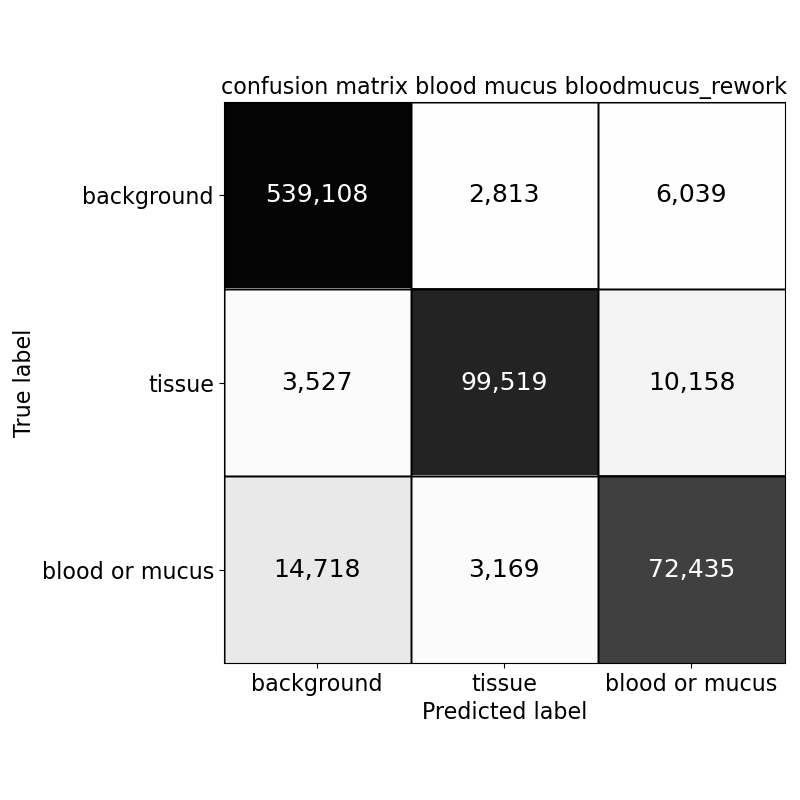

In [48]:
experiment_name1 = "bloodmucus_rework"
experiment_root1 = project_root() / "experiments" / experiment_name1
Image.open(experiment_root1 / "confusion_matrix_3class.png")

0 of 6
1 of 6
2 of 6
3 of 6
4 of 6
5 of 6


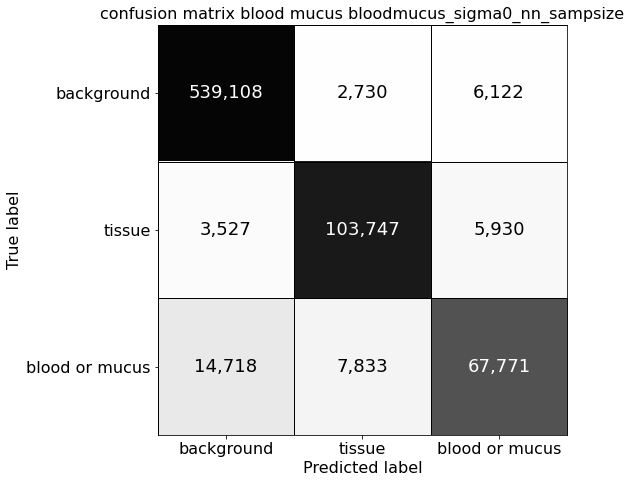

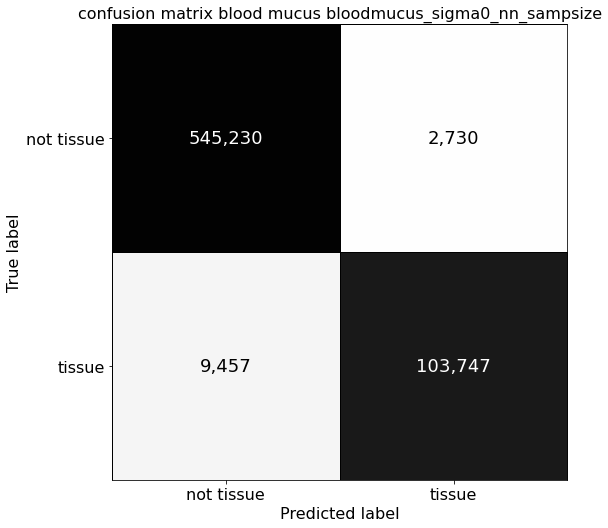

In [41]:
sub_exp_root = experiment_root / "sampsize_100000"
sub_exp_root.mkdir(parents=True, exist_ok=True)
dump(clf1, sub_exp_root / 'nn.joblib')
predict_images(clf1, sub_exp_root)

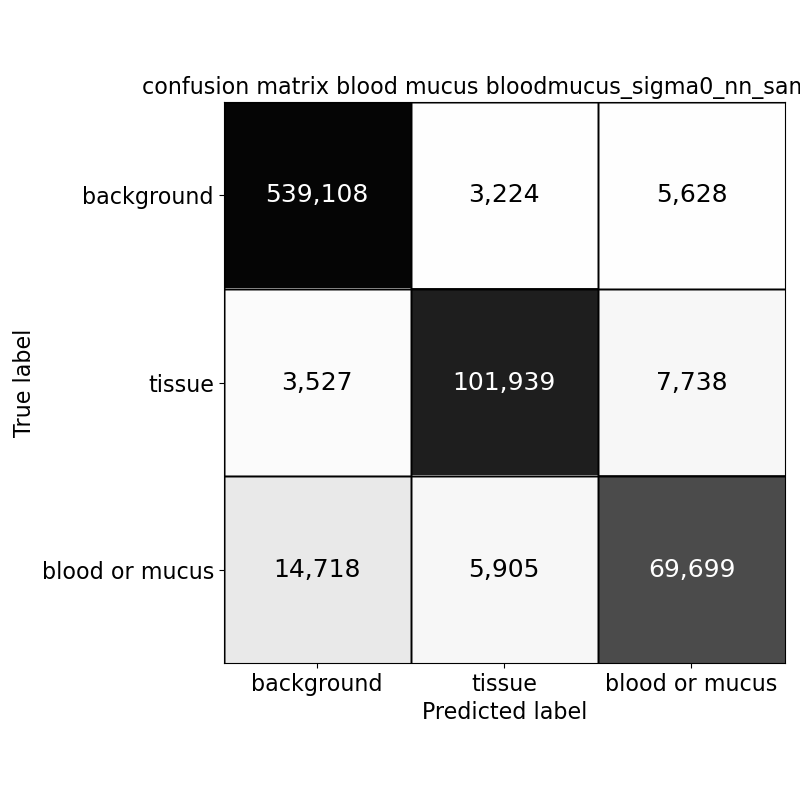

In [42]:
sub_exp_root2 = experiment_root / "deeper_net"

Image.open(sub_exp_root2 / "confusion_matrix_3class.png")

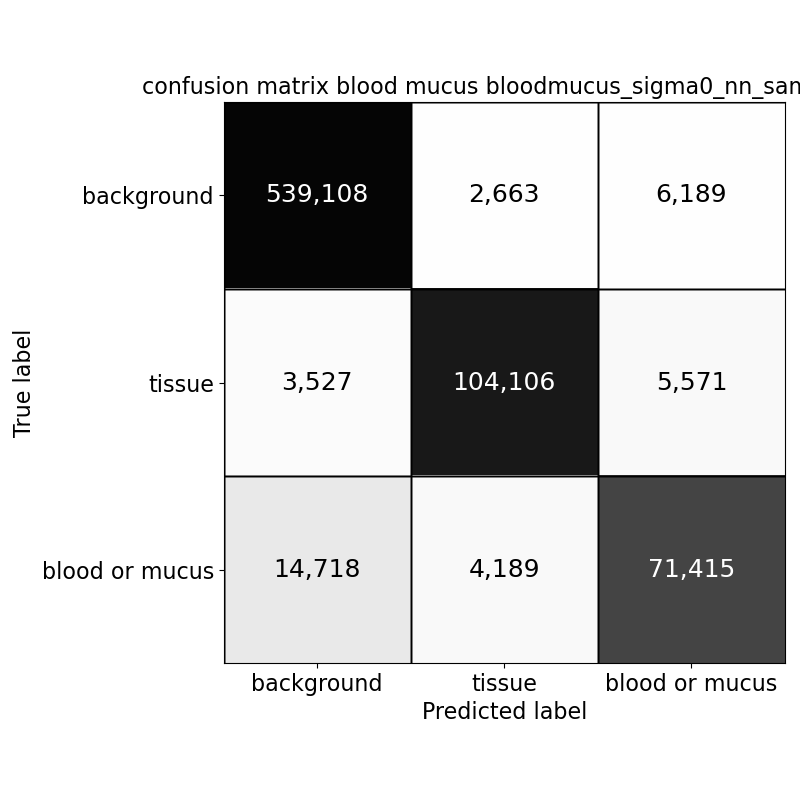

In [46]:
sub_exp_root3 = experiment_root / "shallower_net"

Image.open(sub_exp_root3 / "confusion_matrix_3class.png")

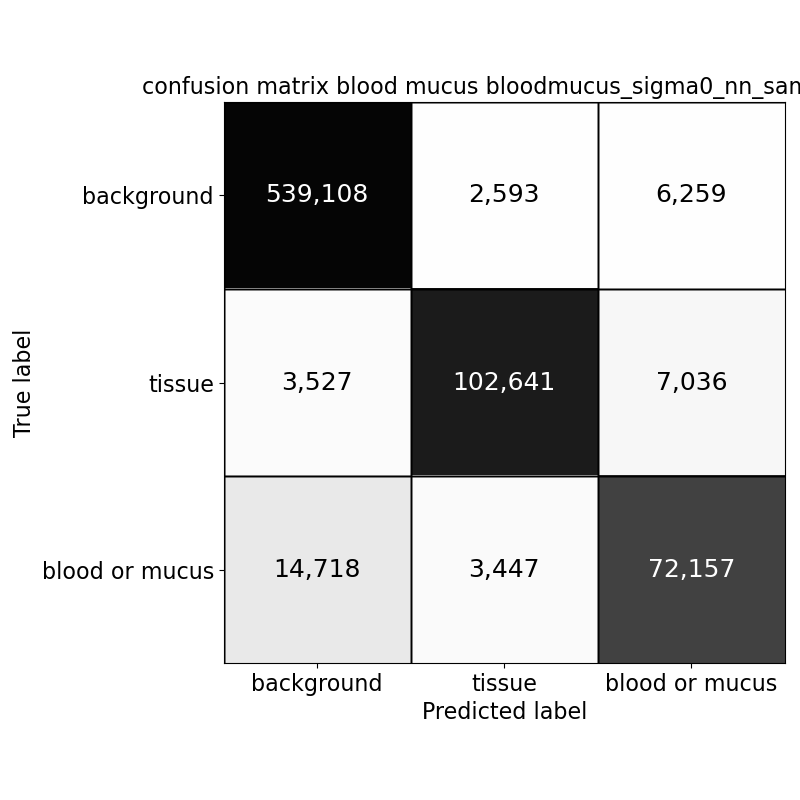

In [51]:
sub_exp_root4 = experiment_root / "wider_net"

Image.open(sub_exp_root4 / "confusion_matrix_3class.png")

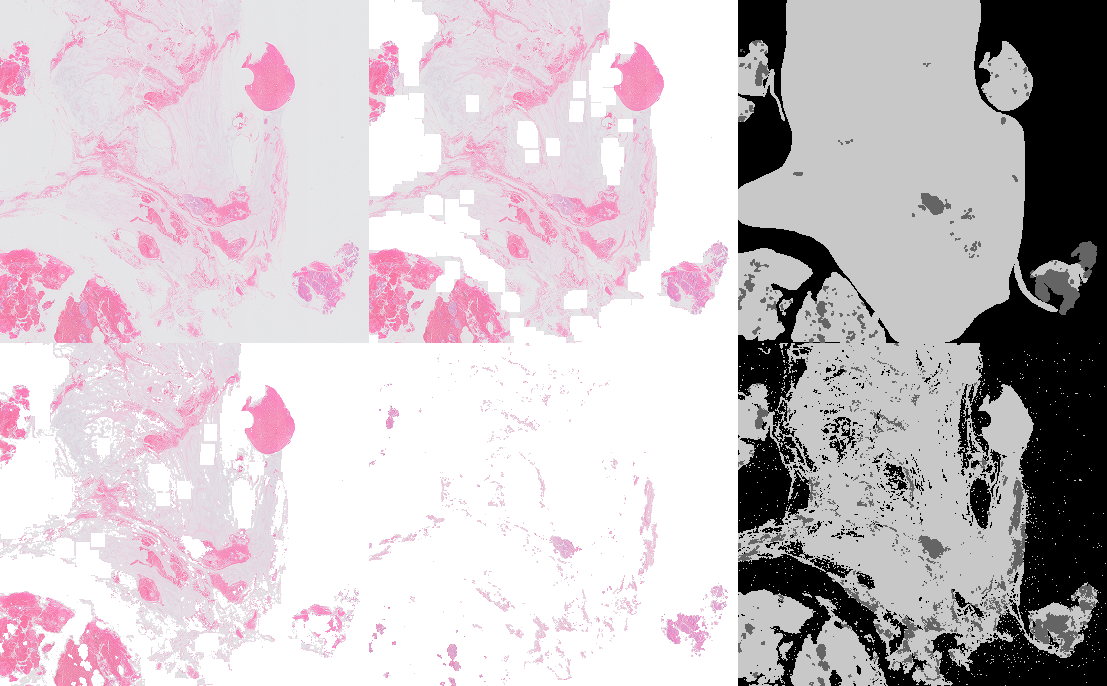

In [43]:
Image.open(sub_exp_root / "0_cd.png")

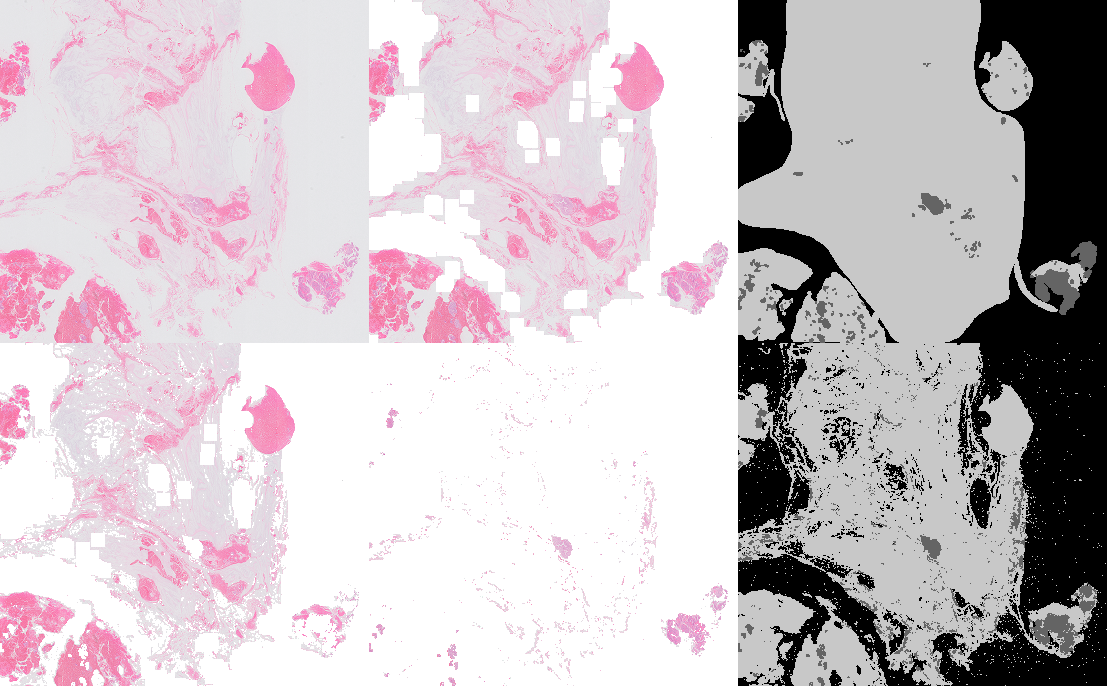

In [45]:
Image.open(sub_exp_root2 / "0_cd.png")

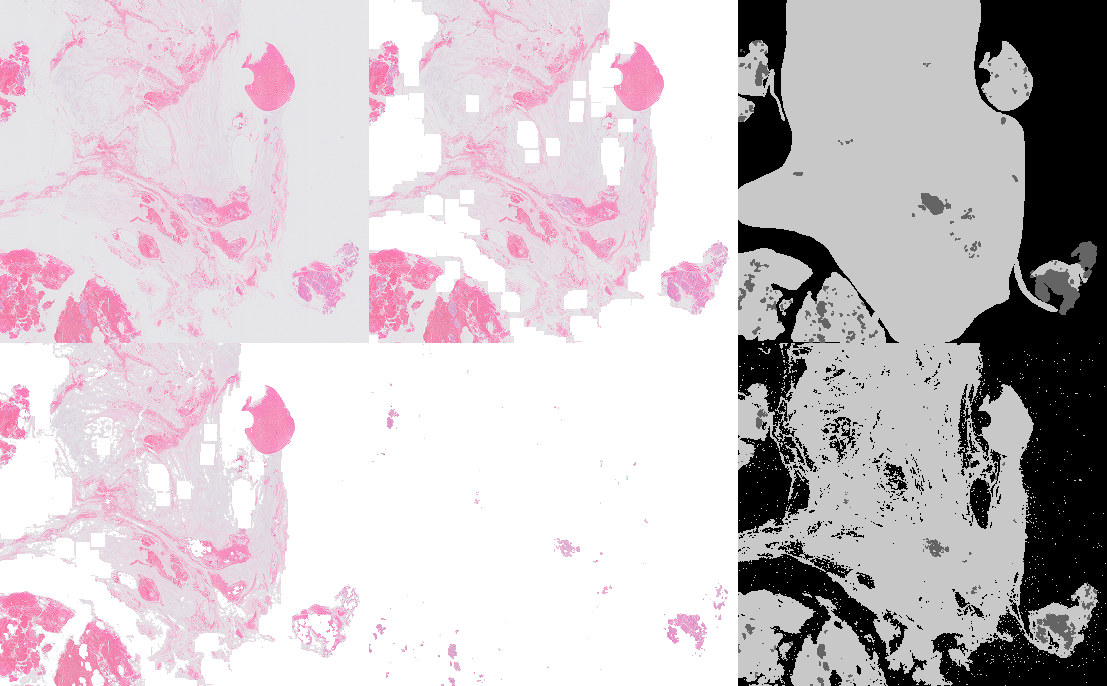

In [50]:
Image.open(experiment_root1 / "mosaic" / "0_cd.png")

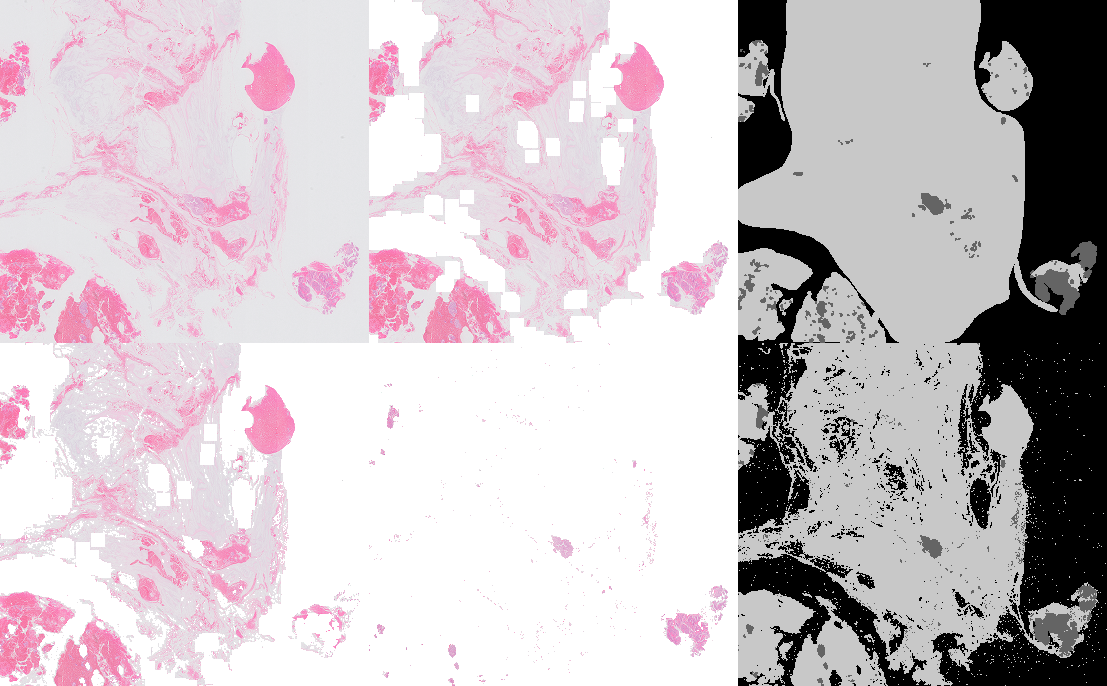

In [47]:
Image.open(sub_exp_root3 / "0_cd.png")

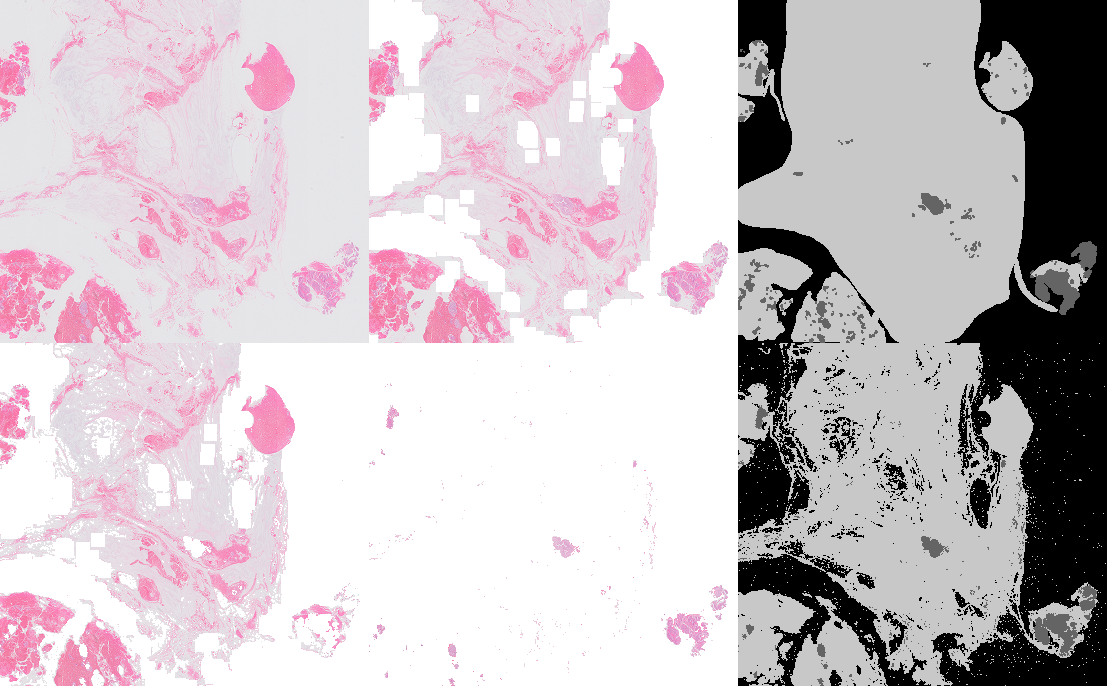

In [52]:
Image.open(sub_exp_root4 / "0_cd.png")

In [53]:
# set values
output_level = 7

# read in validation dataset
dset = bloodm.validation()

# read in slides and for extracting features
thumbz, annotz = get_slides_annots(dset, feature_level, default_label="background")
filtered_thumbz = set_background_to_white(thumbz, tissue_detector)

# read in slides and annotations for plotting and calculating results
thumbz_out, annotz_out = get_slides_annots(dset, output_level, default_label="background")
filtered_thumbz_out = set_background_to_white(thumbz_out, tissue_detector)
annot_areaz = get_annot_areas(dset, output_level)

# settings for pooling from feature level to output level
patch_level = 0
patch_size = 2**output_level
stride = patch_size
scale_factor = 2 ** (feature_level - patch_level)
kernel_size = int(patch_size / scale_factor)
label_level_stride = int(stride / scale_factor)

# create blank confusion matrices
confusion_matrix_2class = np.zeros((len(thumbz), 4))
confusion_matrix_3class = np.zeros((len(thumbz), 9))


In [54]:
for idx, thumb in enumerate(filtered_thumbz[0:1]):
    print(idx, "of", len(filtered_thumbz))
    # get features from pixel feature detector (shape is thumb rows, thumb columns, nfeatures)
    features = pixel_feature_detector(thumb)
    # flatten so shape is 2d (thumb rows * thumb columns, nfeatures)
    features_reshape = features.reshape(-1, features.shape[-1])

    
    
        


0 of 6


NameError: name 'clf' is not defined

In [55]:
# predict from features
output = clf1.predict(features_reshape)

In [56]:
output_probs = clf1.predict_proba(features_reshape)

In [57]:
output_probs

array([[0.00298813, 0.00619096, 0.95443681, 0.0363841 ],
       [0.00298813, 0.00619096, 0.95443681, 0.0363841 ],
       [0.00298813, 0.00619096, 0.95443681, 0.0363841 ],
       ...,
       [0.00298813, 0.00619096, 0.95443681, 0.0363841 ],
       [0.00298813, 0.00619096, 0.95443681, 0.0363841 ],
       [0.00298813, 0.00619096, 0.95443681, 0.0363841 ]])

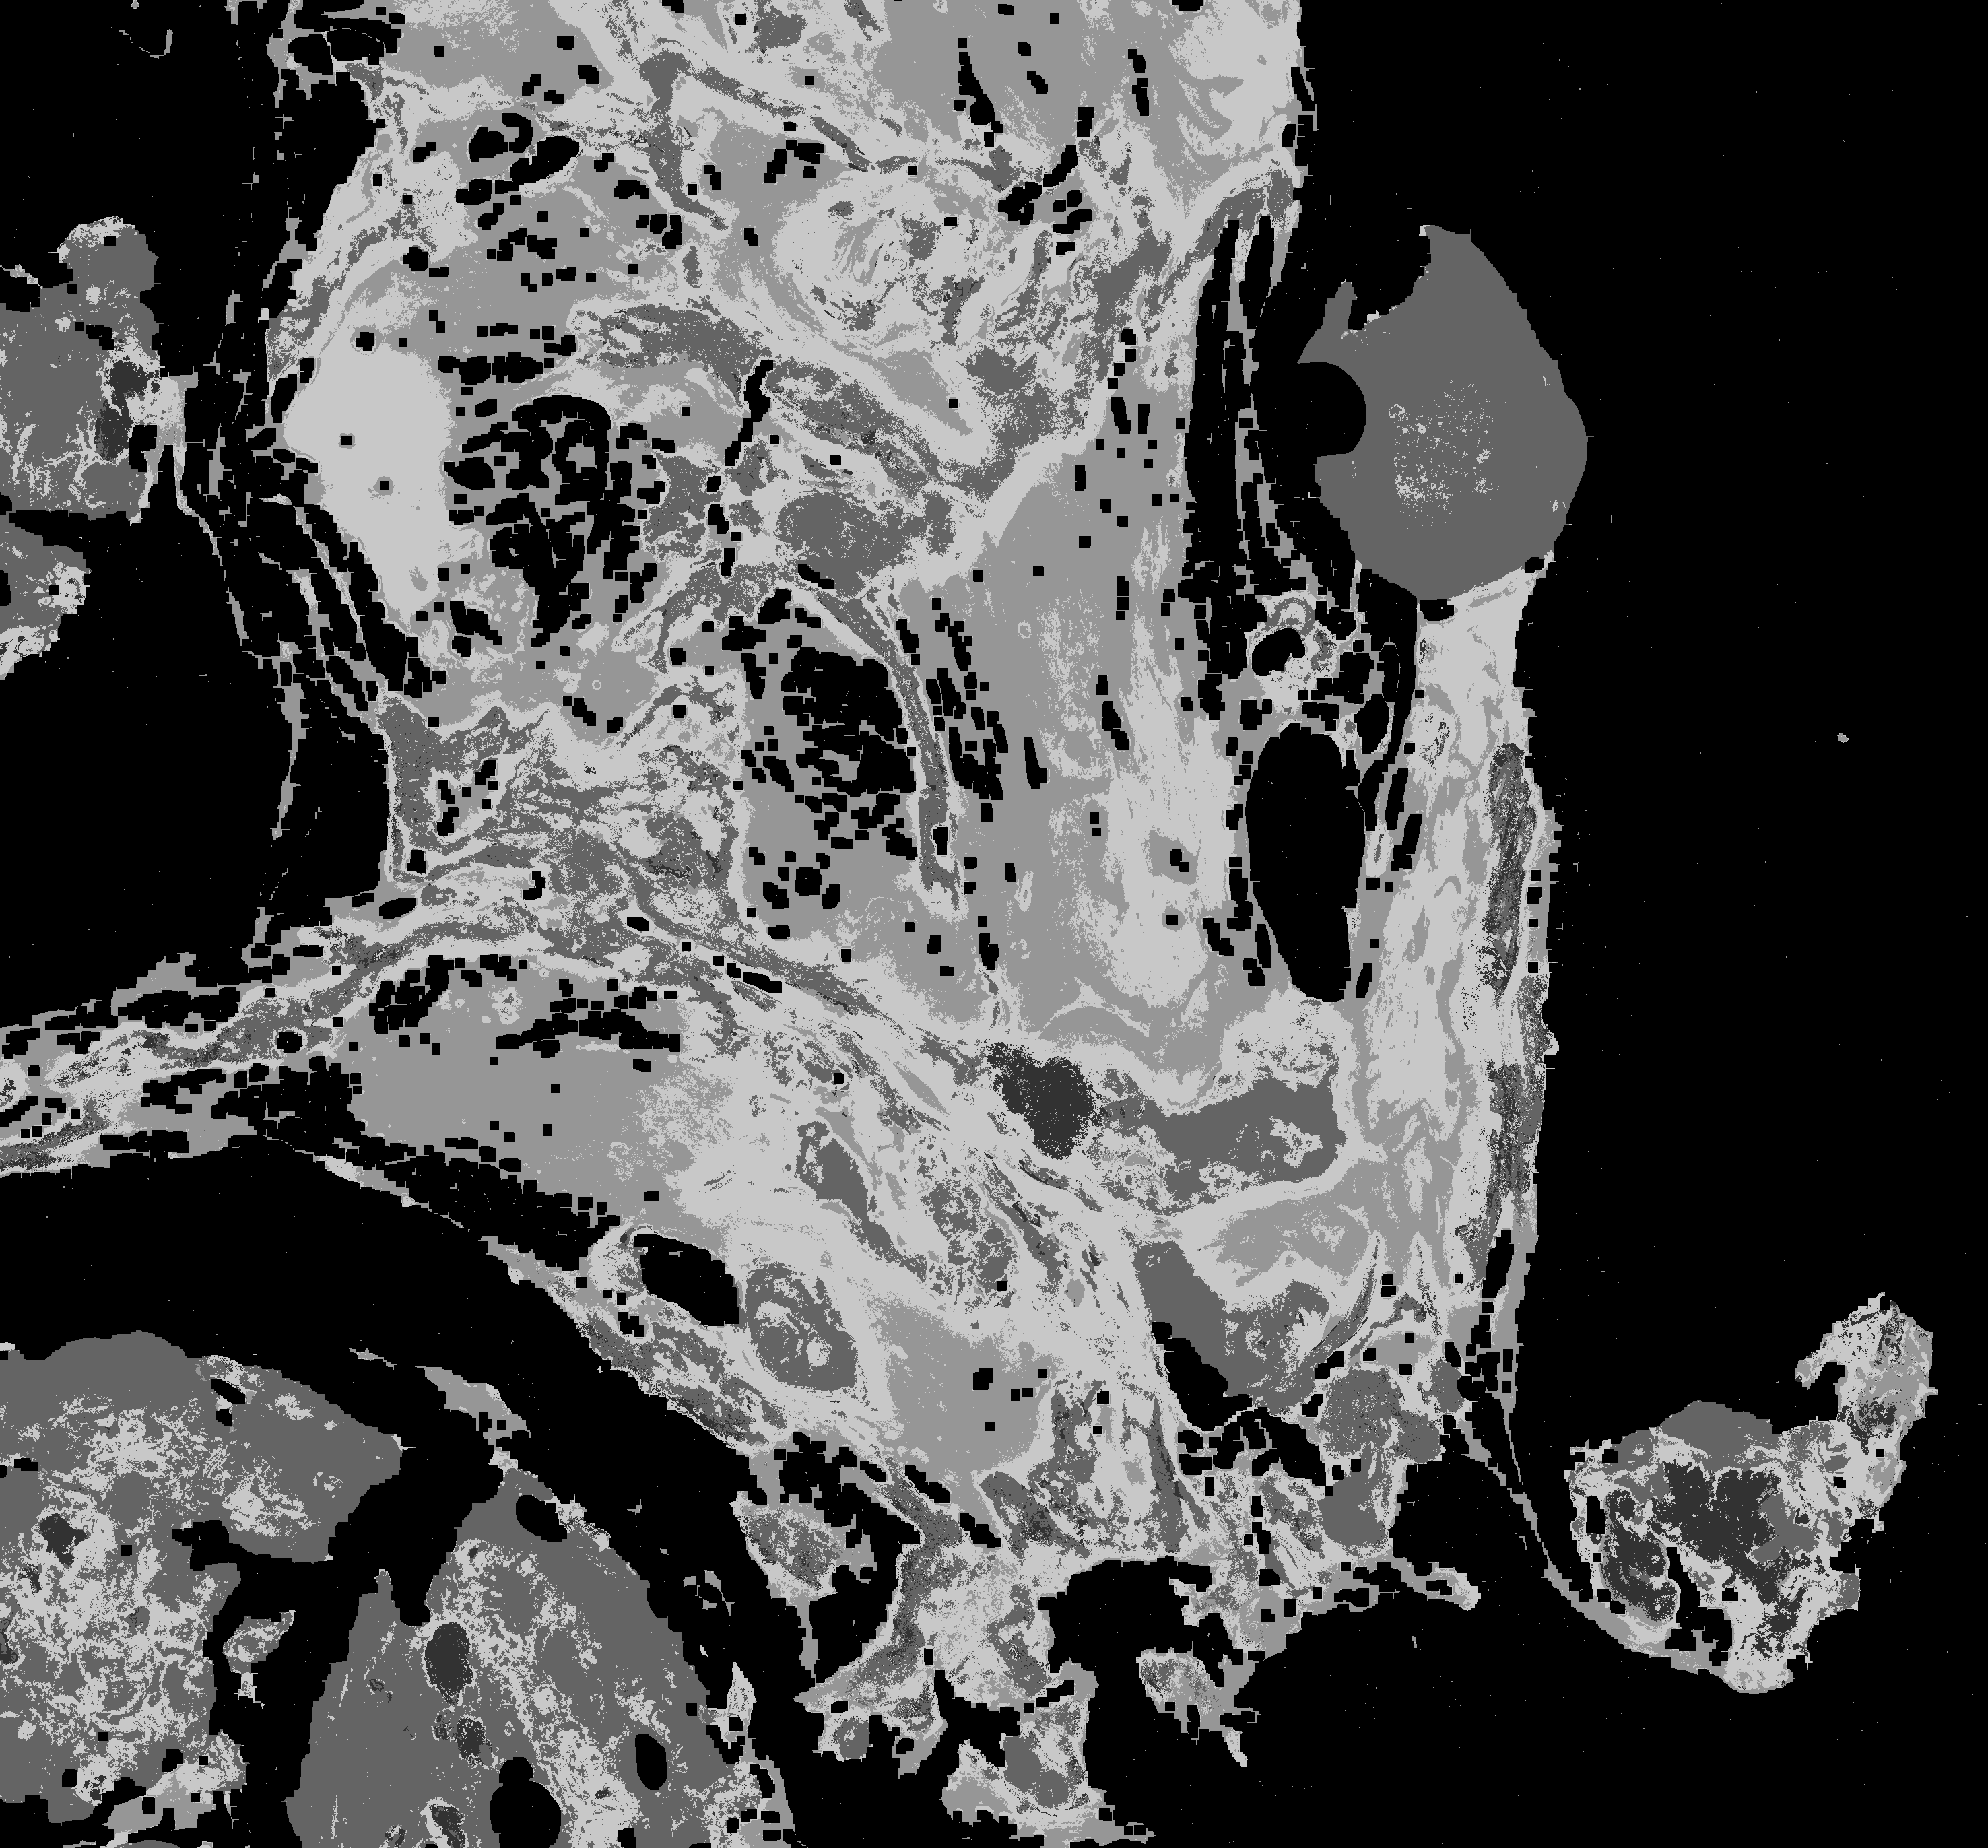

In [64]:
# reshape back to thumb shape
labels_image = np.reshape(output, (thumb.shape[:-1]))
# use tissue detector to set background values to zero
tissue_mask = tissue_detector(thumb)
filtered_labels_image = np.where(np.logical_not(tissue_mask), 0, labels_image)

# get area which is fuly annotated and calculate position
annot_area = annot_areaz[0]
pixvals = np.where(annot_area > 0)
minrw = min(pixvals[0])
maxrw = max(pixvals[0])+1
mincl = min(pixvals[1])
maxcl = max(pixvals[1])+1

# get area feat lev
lev_diff = output_level - feature_level
minrwf = minrw*2**lev_diff
maxrwf = maxrw*2**lev_diff
minclf = mincl*2**lev_diff
maxclf = maxcl*2**lev_diff


cd_fil_lab_im = filtered_labels_image[minrwf:maxrwf, minclf:maxclf]
Image.fromarray(np.array(cd_fil_lab_im,dtype=np.uint8)*50)

In [65]:
print(output.shape, output_probs[:, 0].shape)

(47566980,) (47566980,)


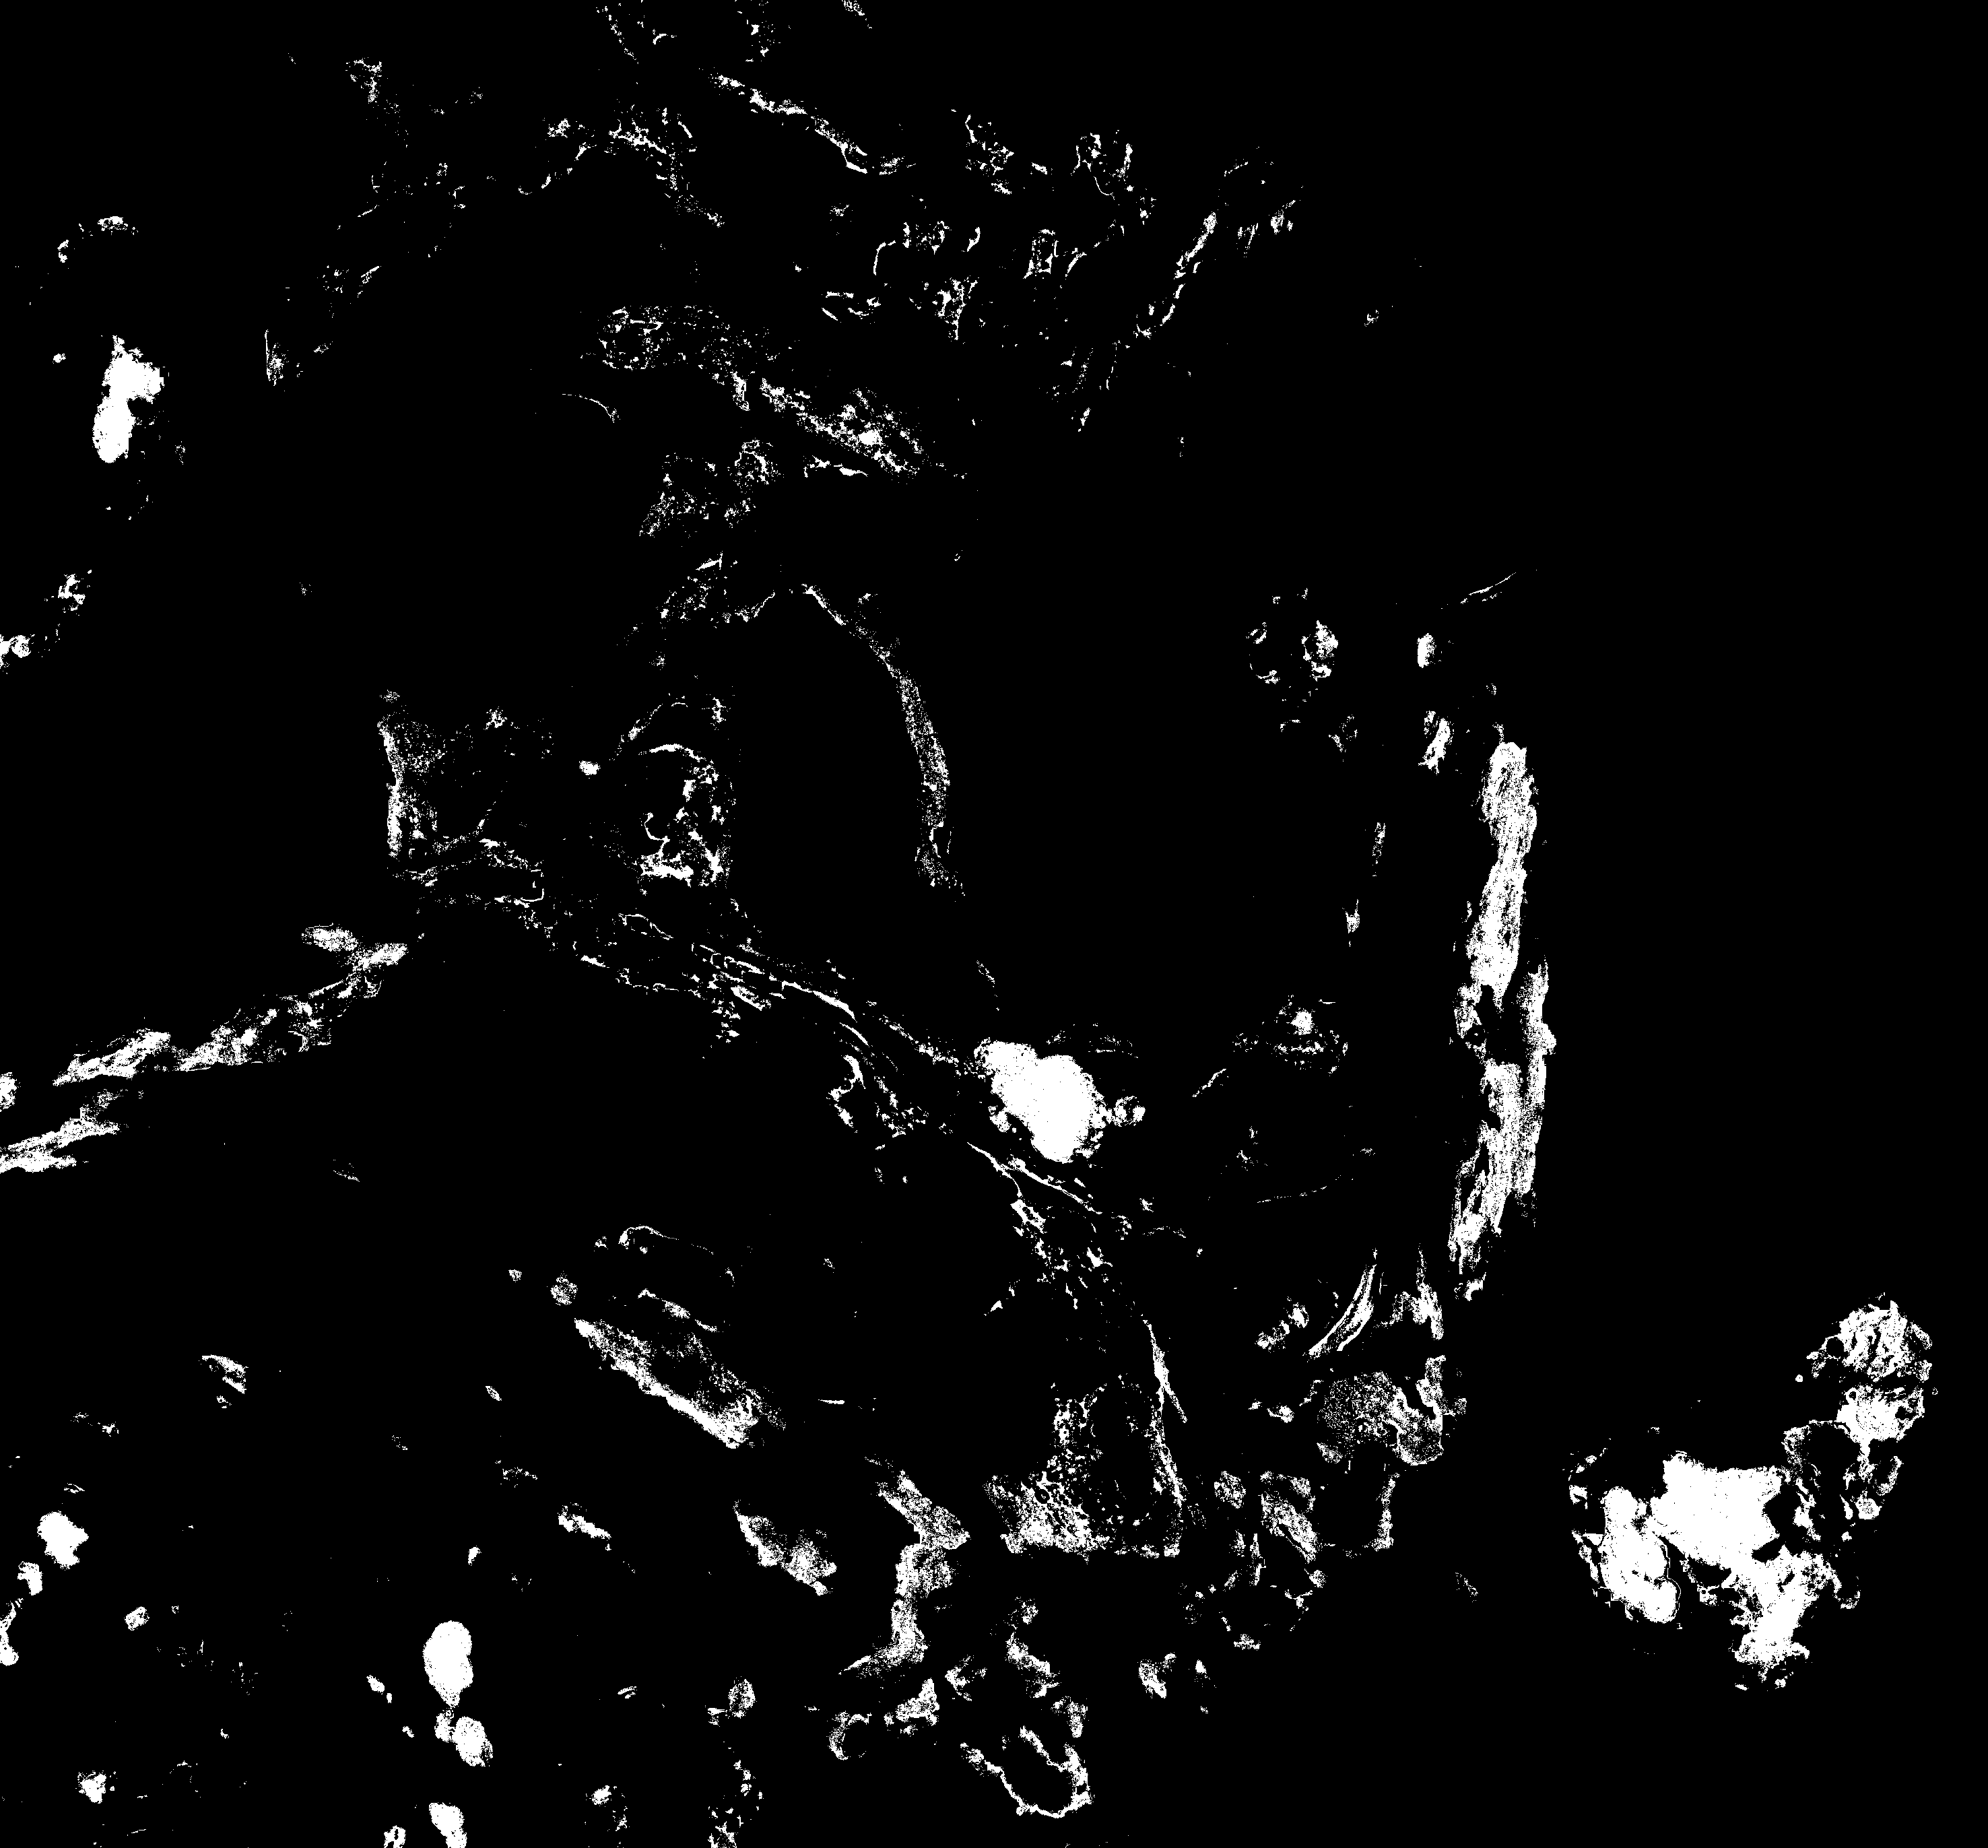

In [70]:
# reshape back to thumb shape
probs_image = np.reshape(output_probs[:, 0], (thumb.shape[:-1]))
# use tissue detector to set background values to zero
filtered_probs_image = np.where(np.logical_not(tissue_mask), 0, probs_image)
cd_fil_prob_im = filtered_probs_image[minrwf:maxrwf, minclf:maxclf]
Image.fromarray(np.array((cd_fil_prob_im>0.1)*255,dtype=np.uint8))

In [72]:
from joblib import load

experiment_name7 = "bloodmucus_sigma0"
experiment_root7 = project_root() / "experiments" / experiment_name7

clf2 = load(experiment_root / 'rforest.joblib')

In [74]:
output2 = clf2.predict(features_reshape)
output_probs2 = clf2.predict_proba(features_reshape)

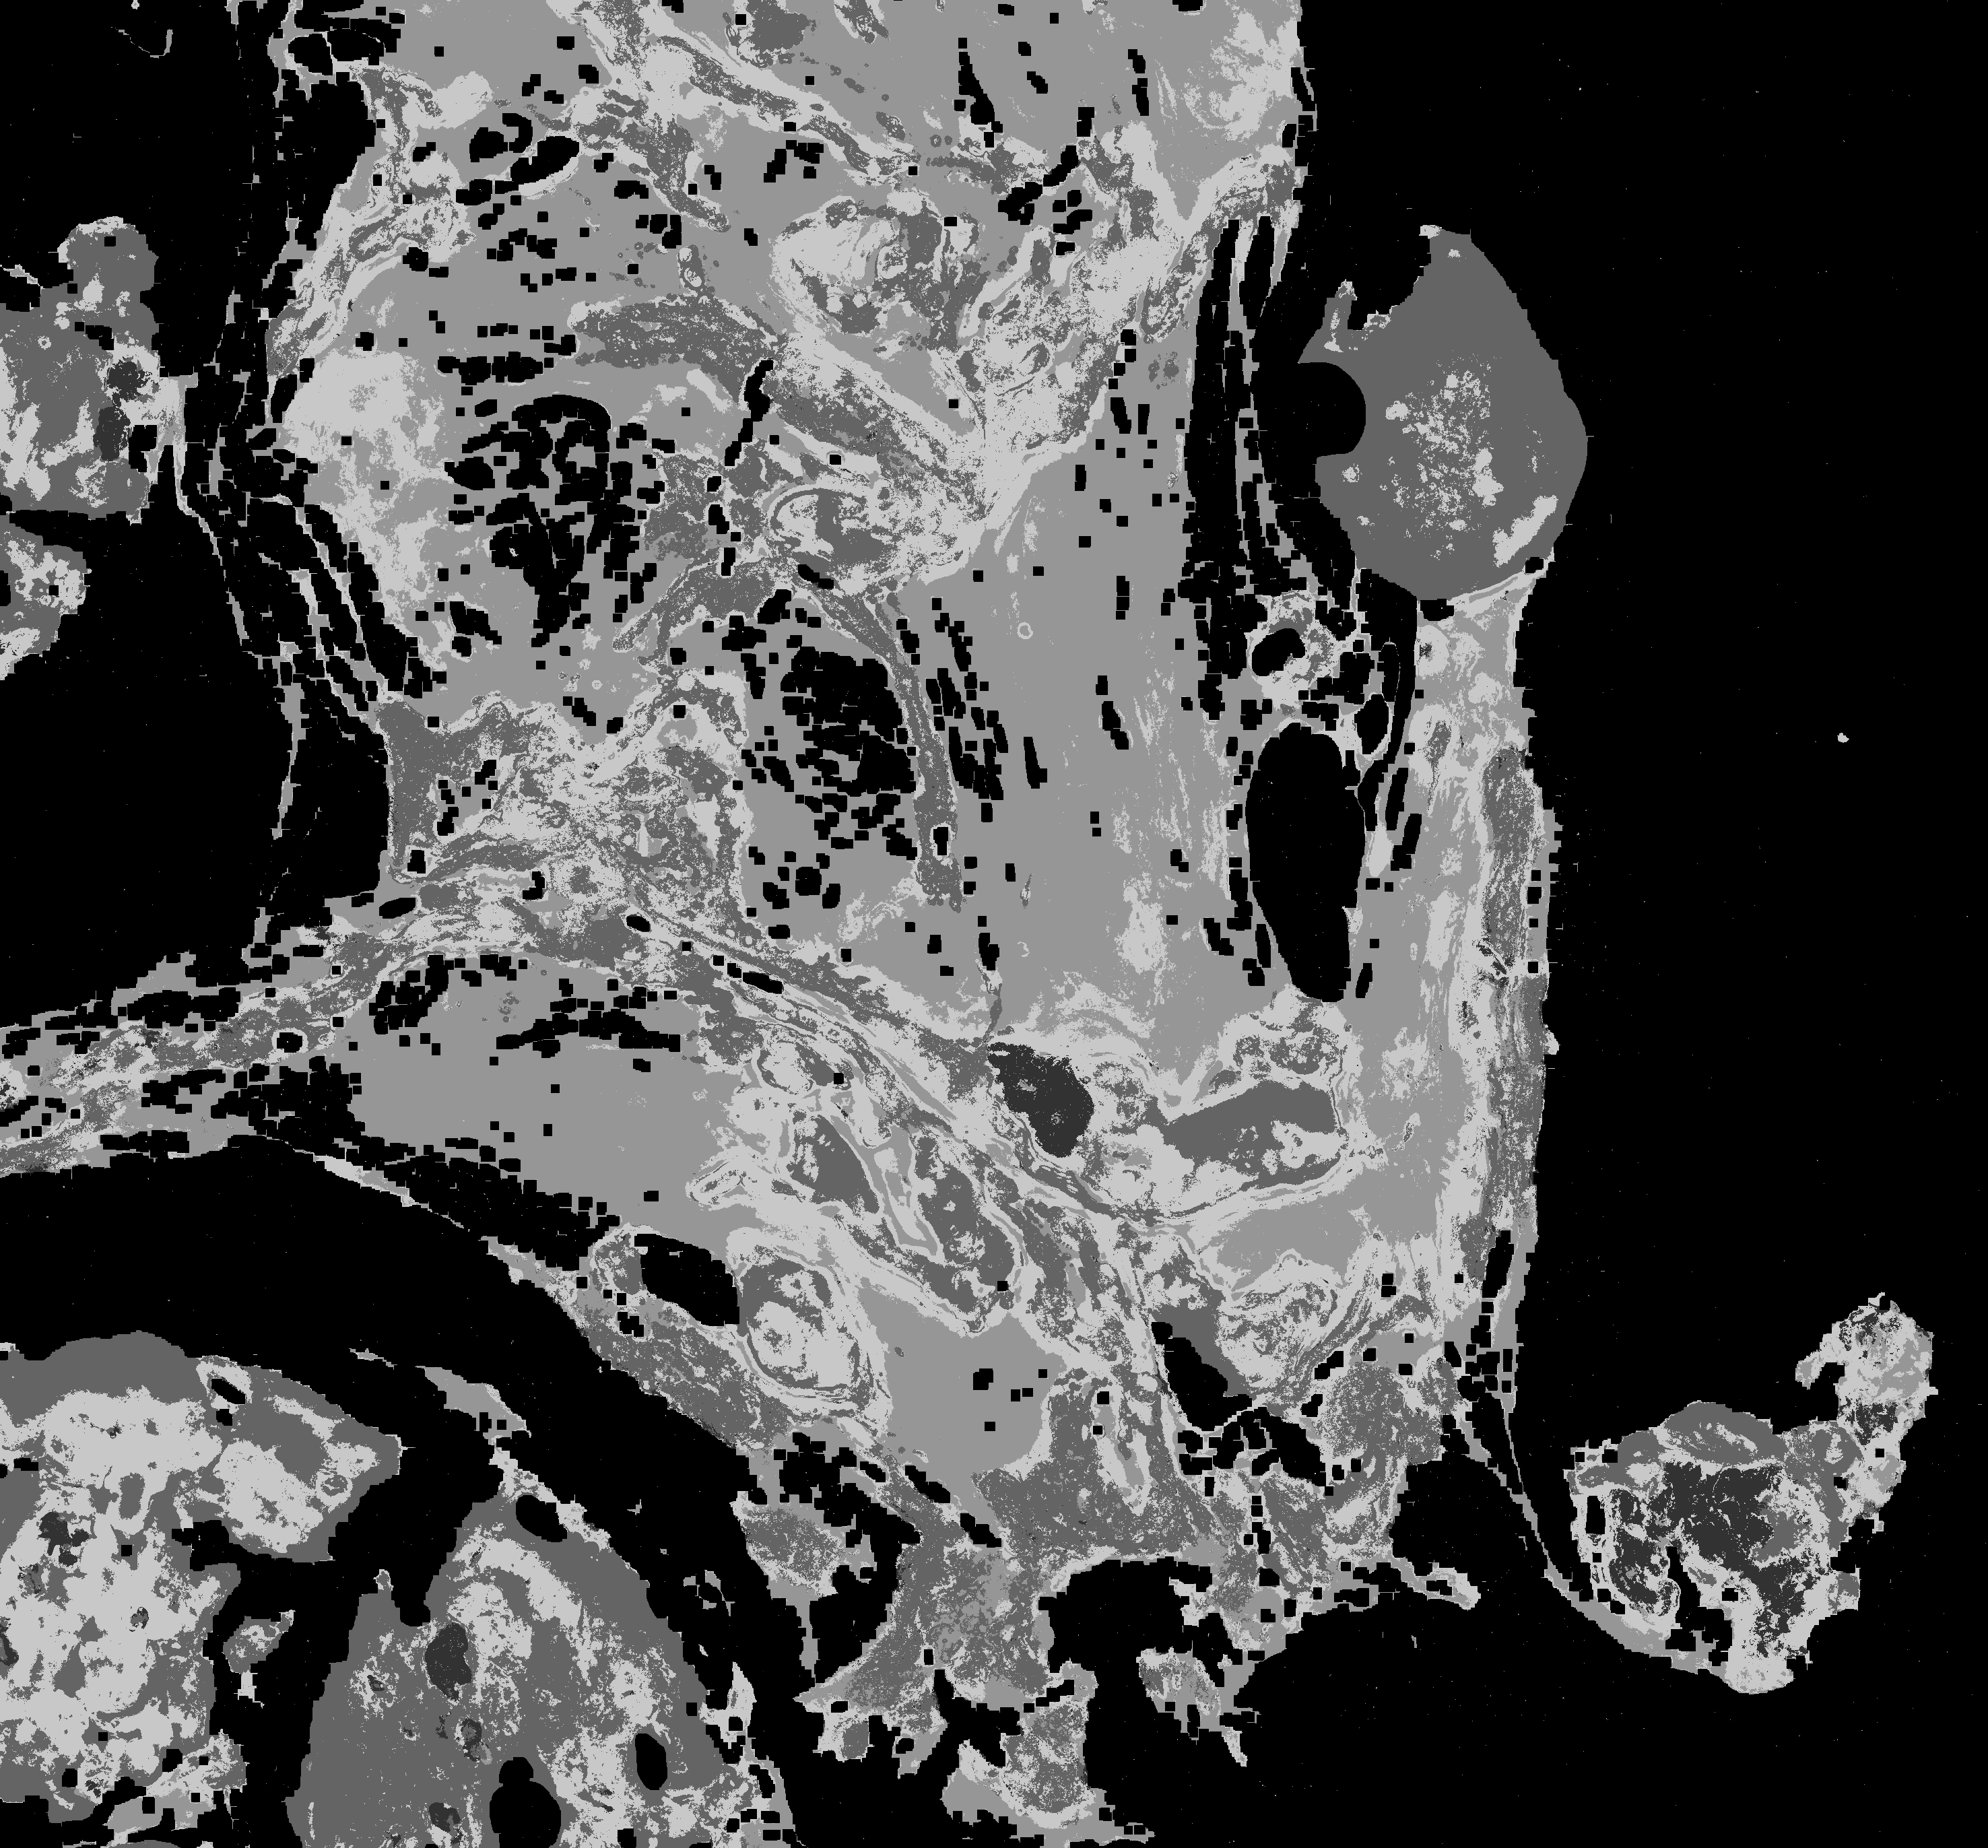

In [75]:
# reshape back to thumb shape
labels_image2 = np.reshape(output2, (thumb.shape[:-1]))
# use tissue detector to set background values to zero
filtered_labels_image2 = np.where(np.logical_not(tissue_mask), 0, labels_image2)
cd_fil_lab_im2 = filtered_labels_image2[minrwf:maxrwf, minclf:maxclf]
Image.fromarray(np.array(cd_fil_lab_im2,dtype=np.uint8)*50)

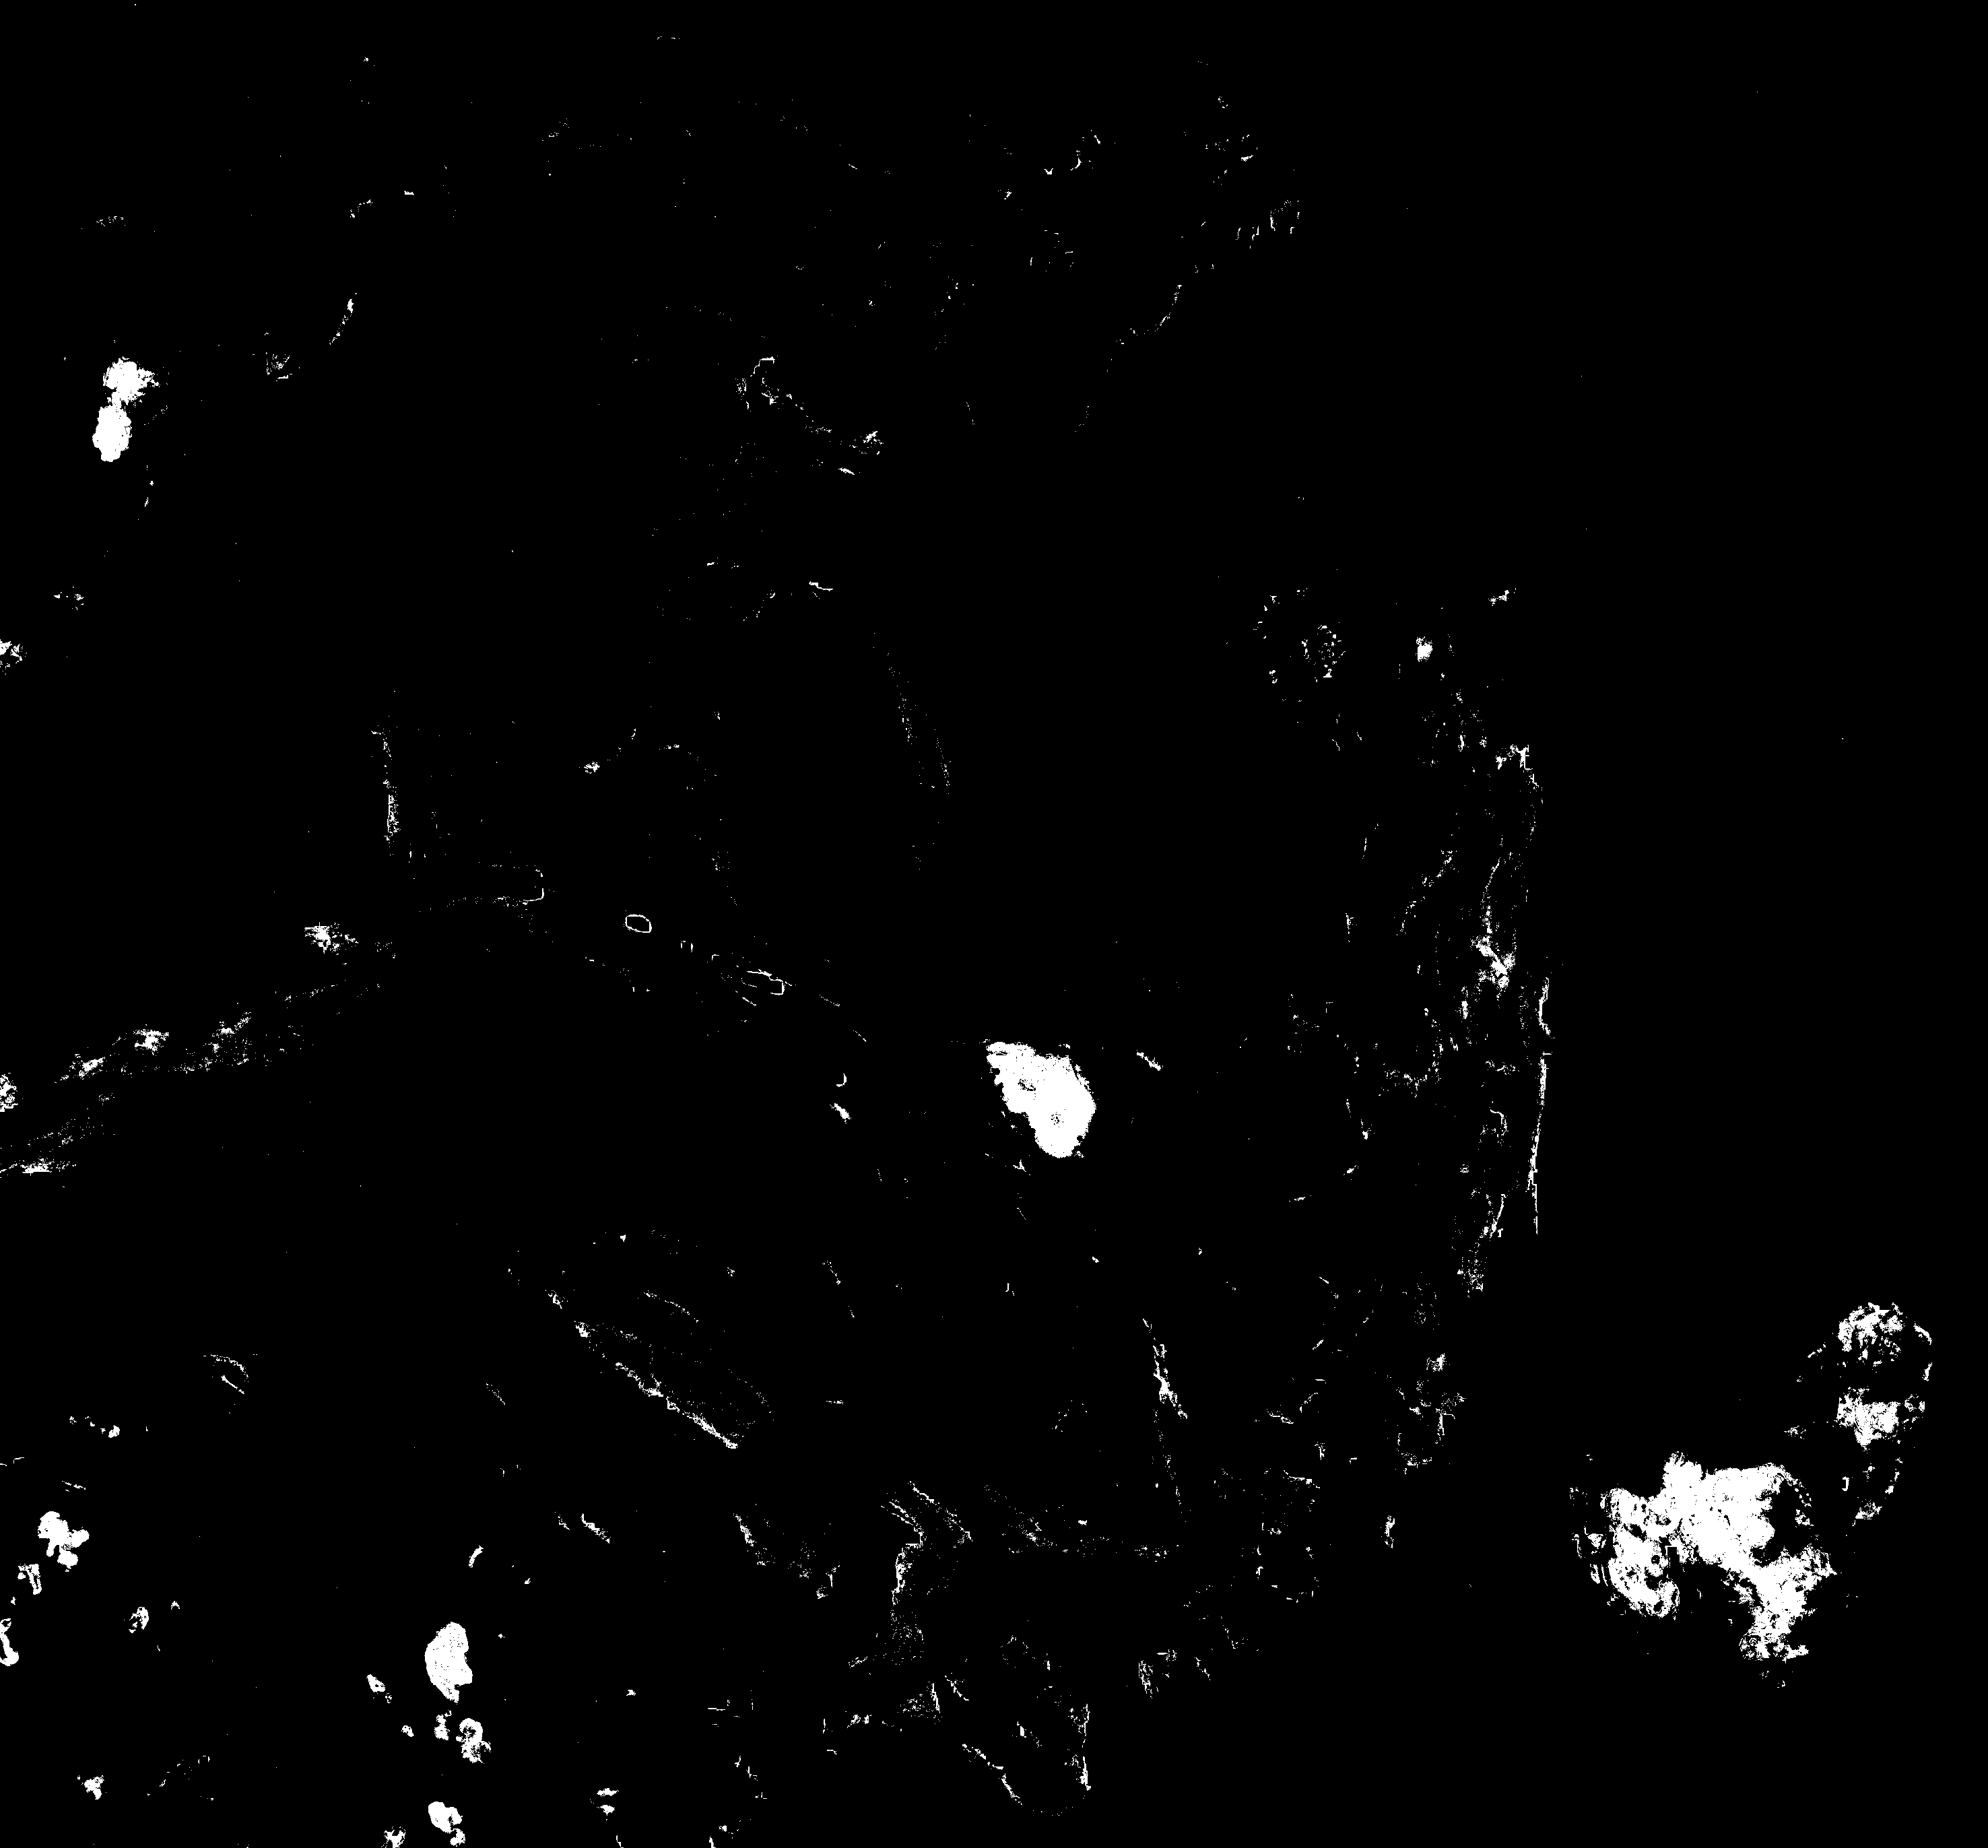

In [89]:
# reshape back to thumb shape
probs_image2 = np.reshape(output_probs2[:, 0], (thumb.shape[:-1]))
# use tissue detector to set background values to zero
filtered_probs_image2 = np.where(np.logical_not(tissue_mask), 0, probs_image2)
cd_fil_prob_im2 = filtered_probs_image2[minrwf:maxrwf, minclf:maxclf]
Image.fromarray(np.array((cd_fil_prob_im2>0.25)*255,dtype=np.uint8))

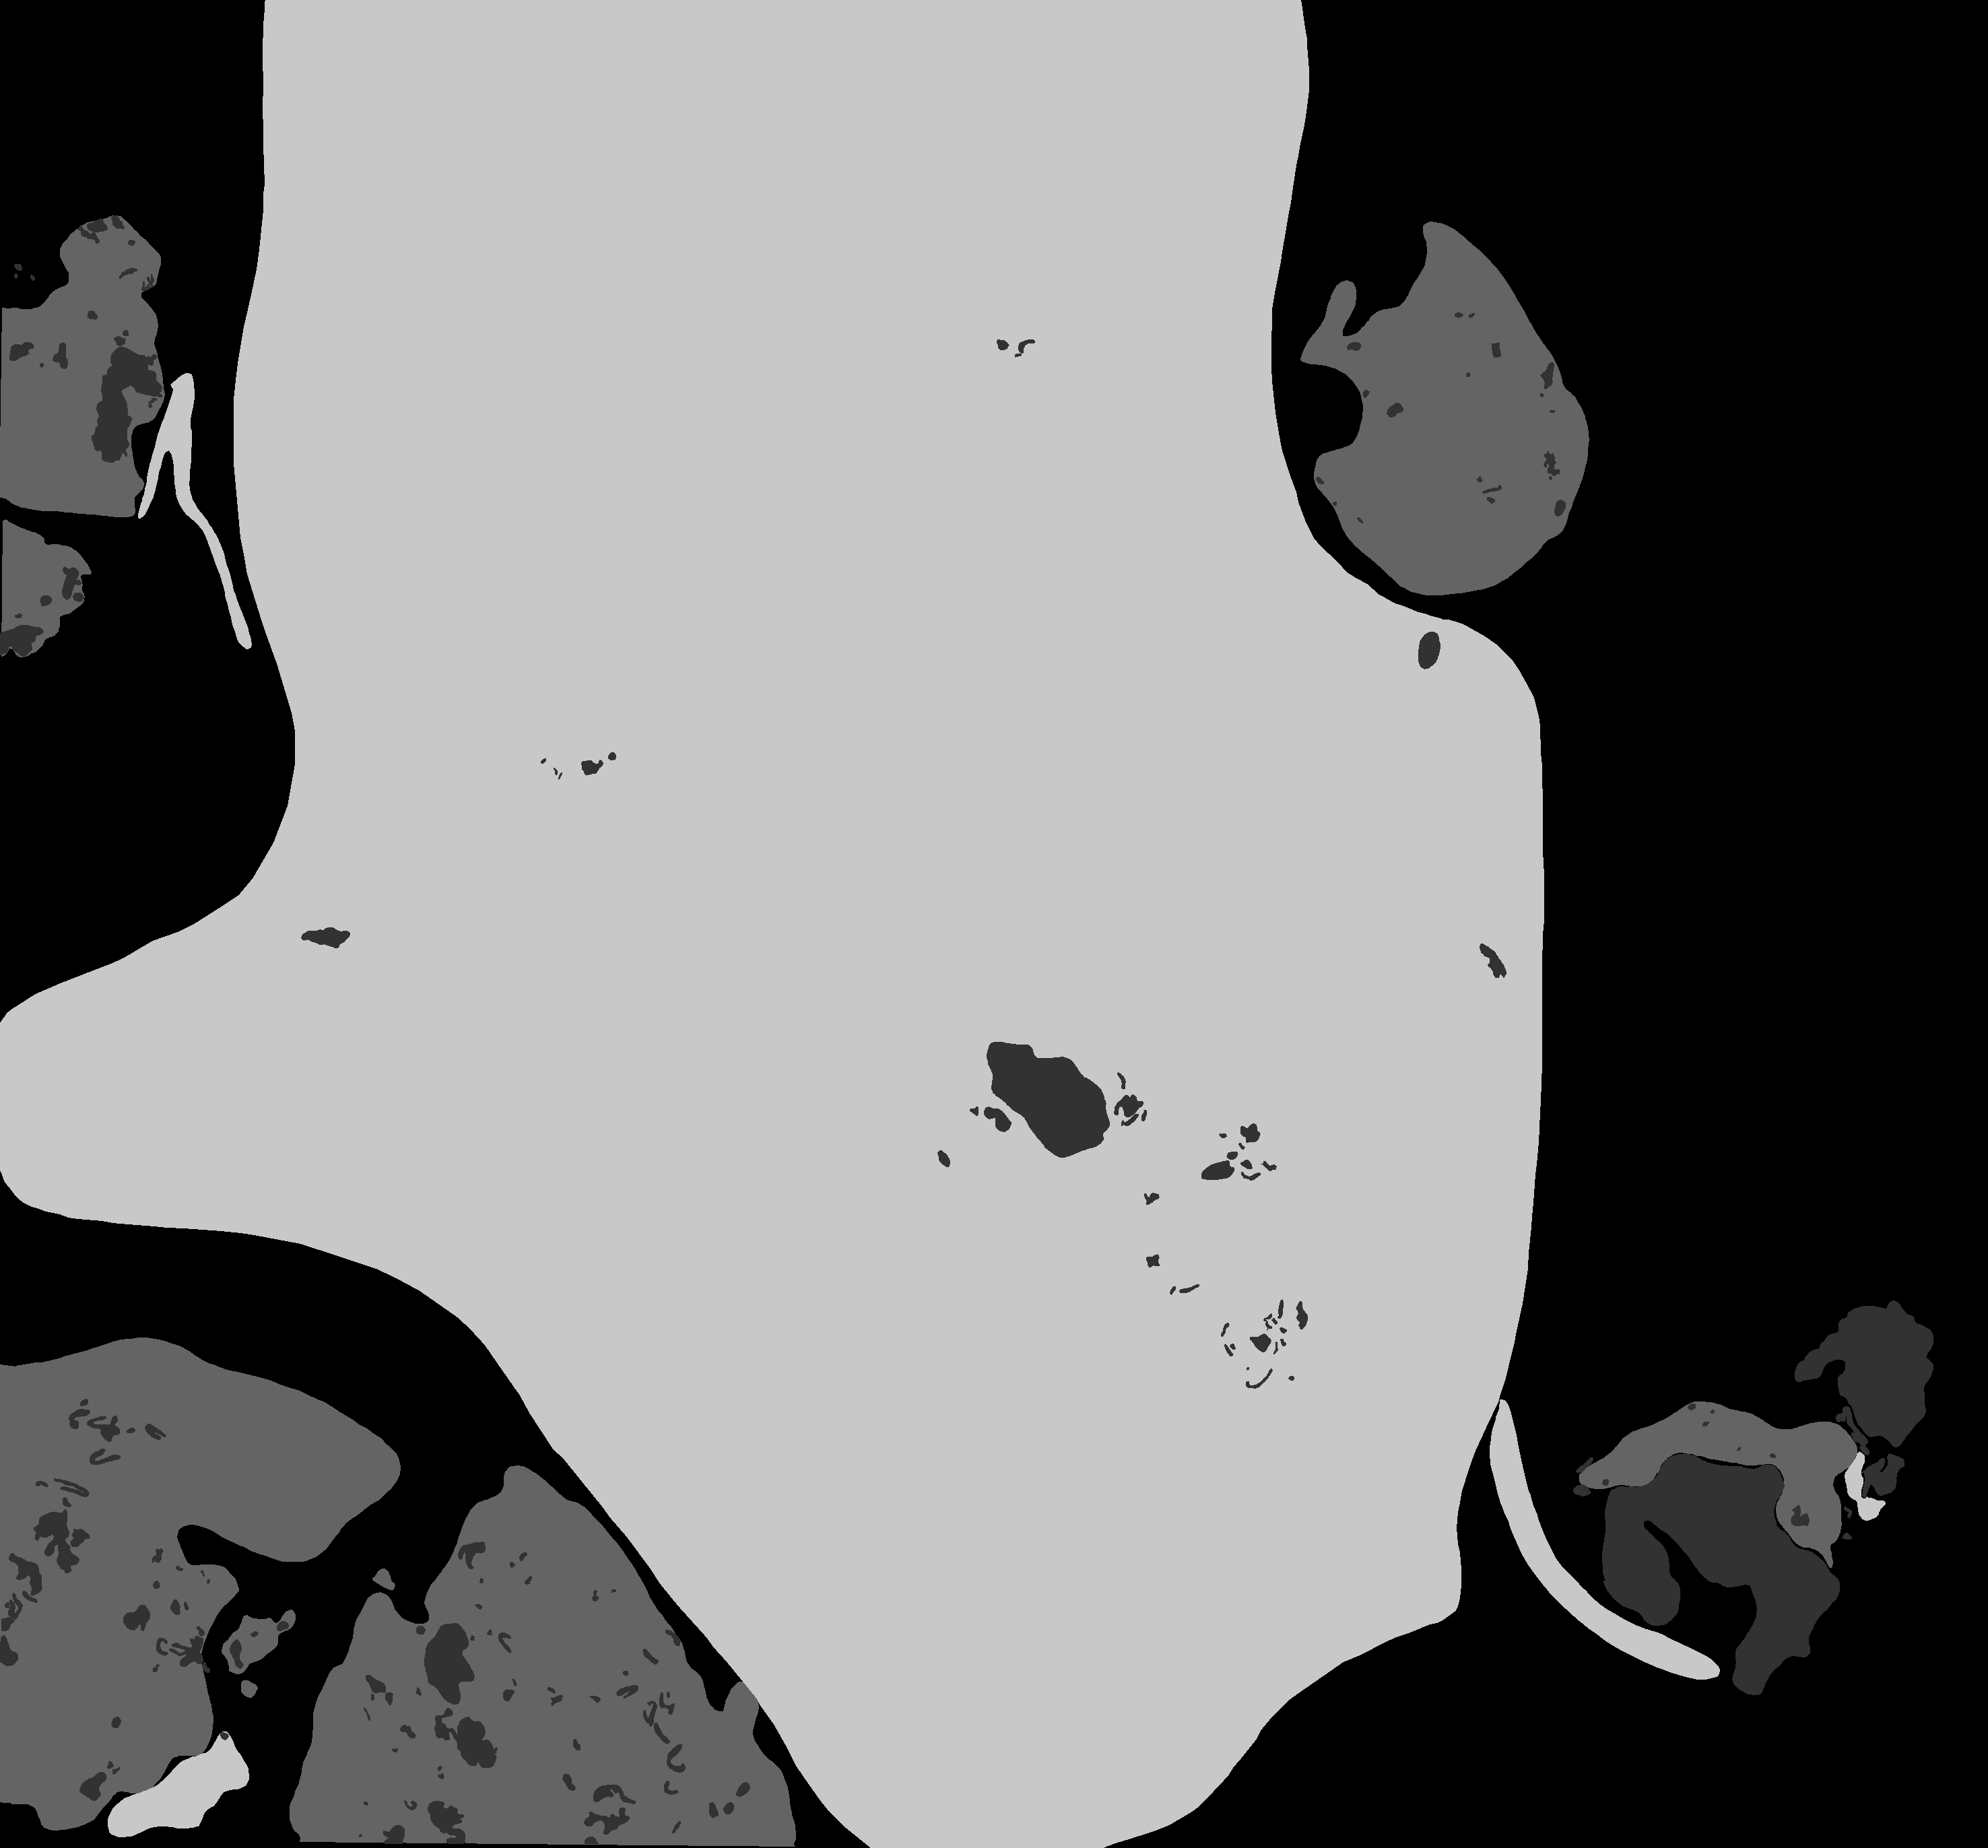

In [85]:
annot_cd = annotz[0][minrwf:maxrwf,minclf:maxclf]
Image.fromarray(np.array(annot_cd, dtype=np.uint8)*50)

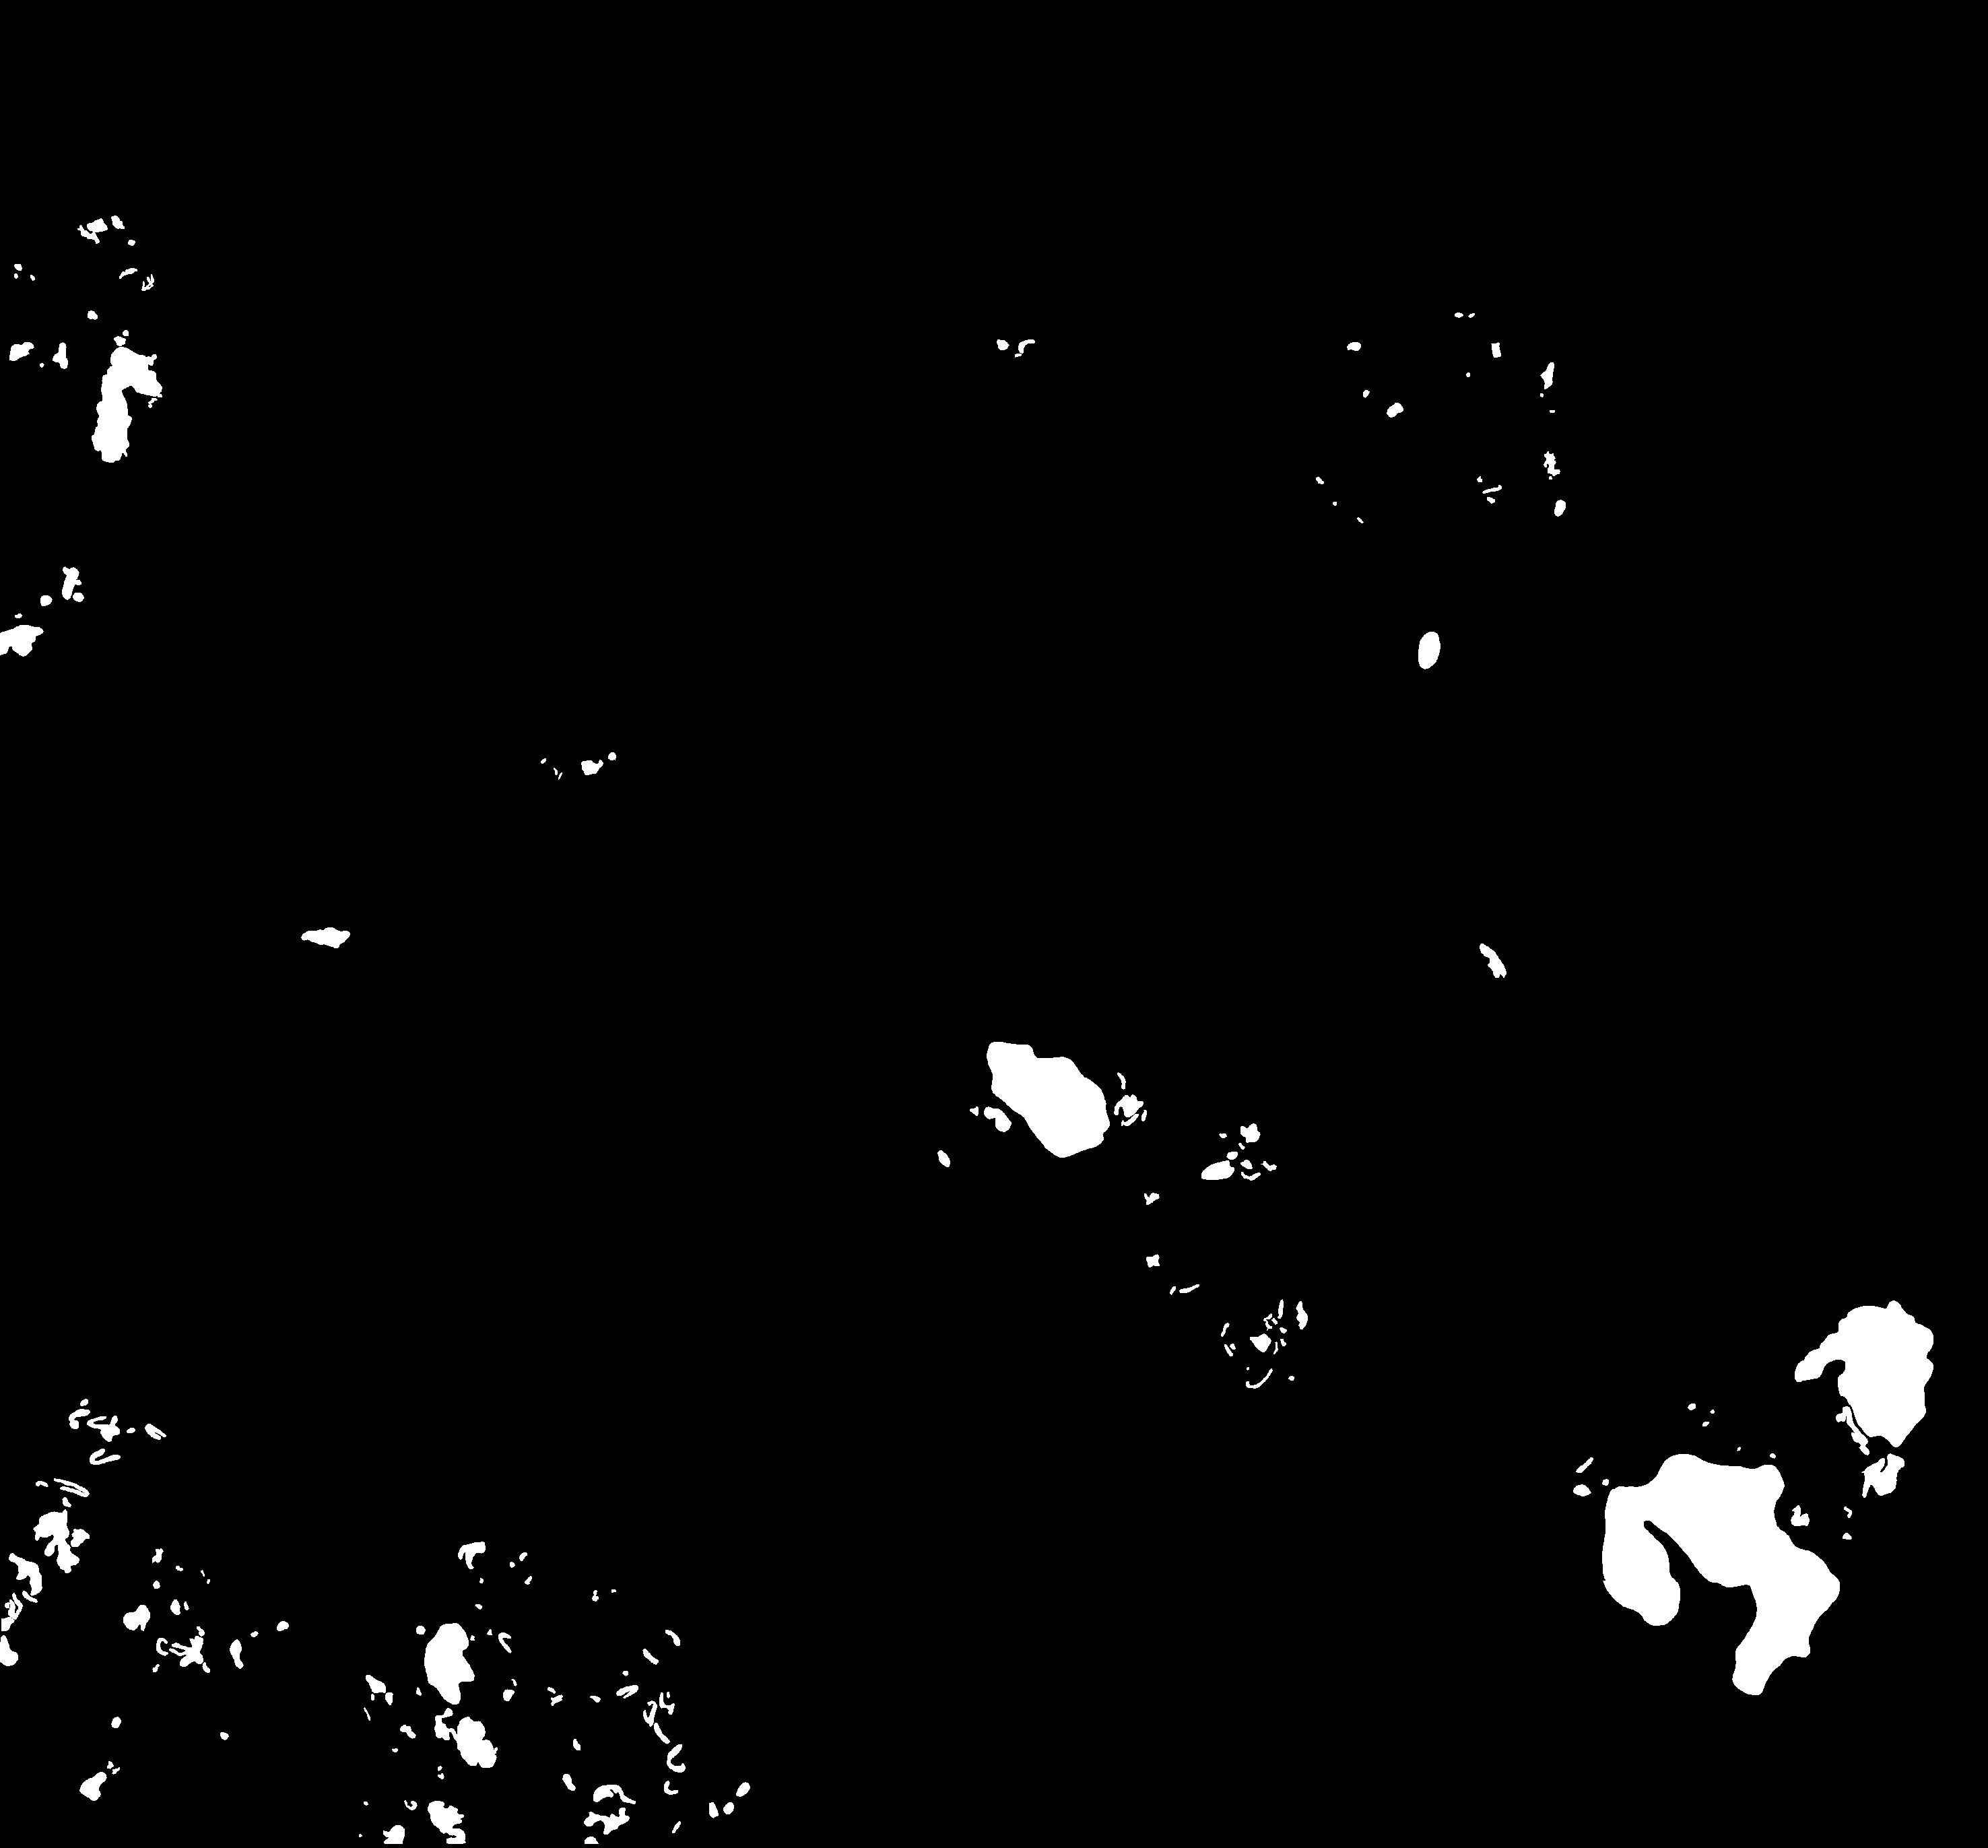

In [86]:
tissue_annot = annot_cd == 1
Image.fromarray(np.array(tissue_annot*255, dtype=np.uint8))

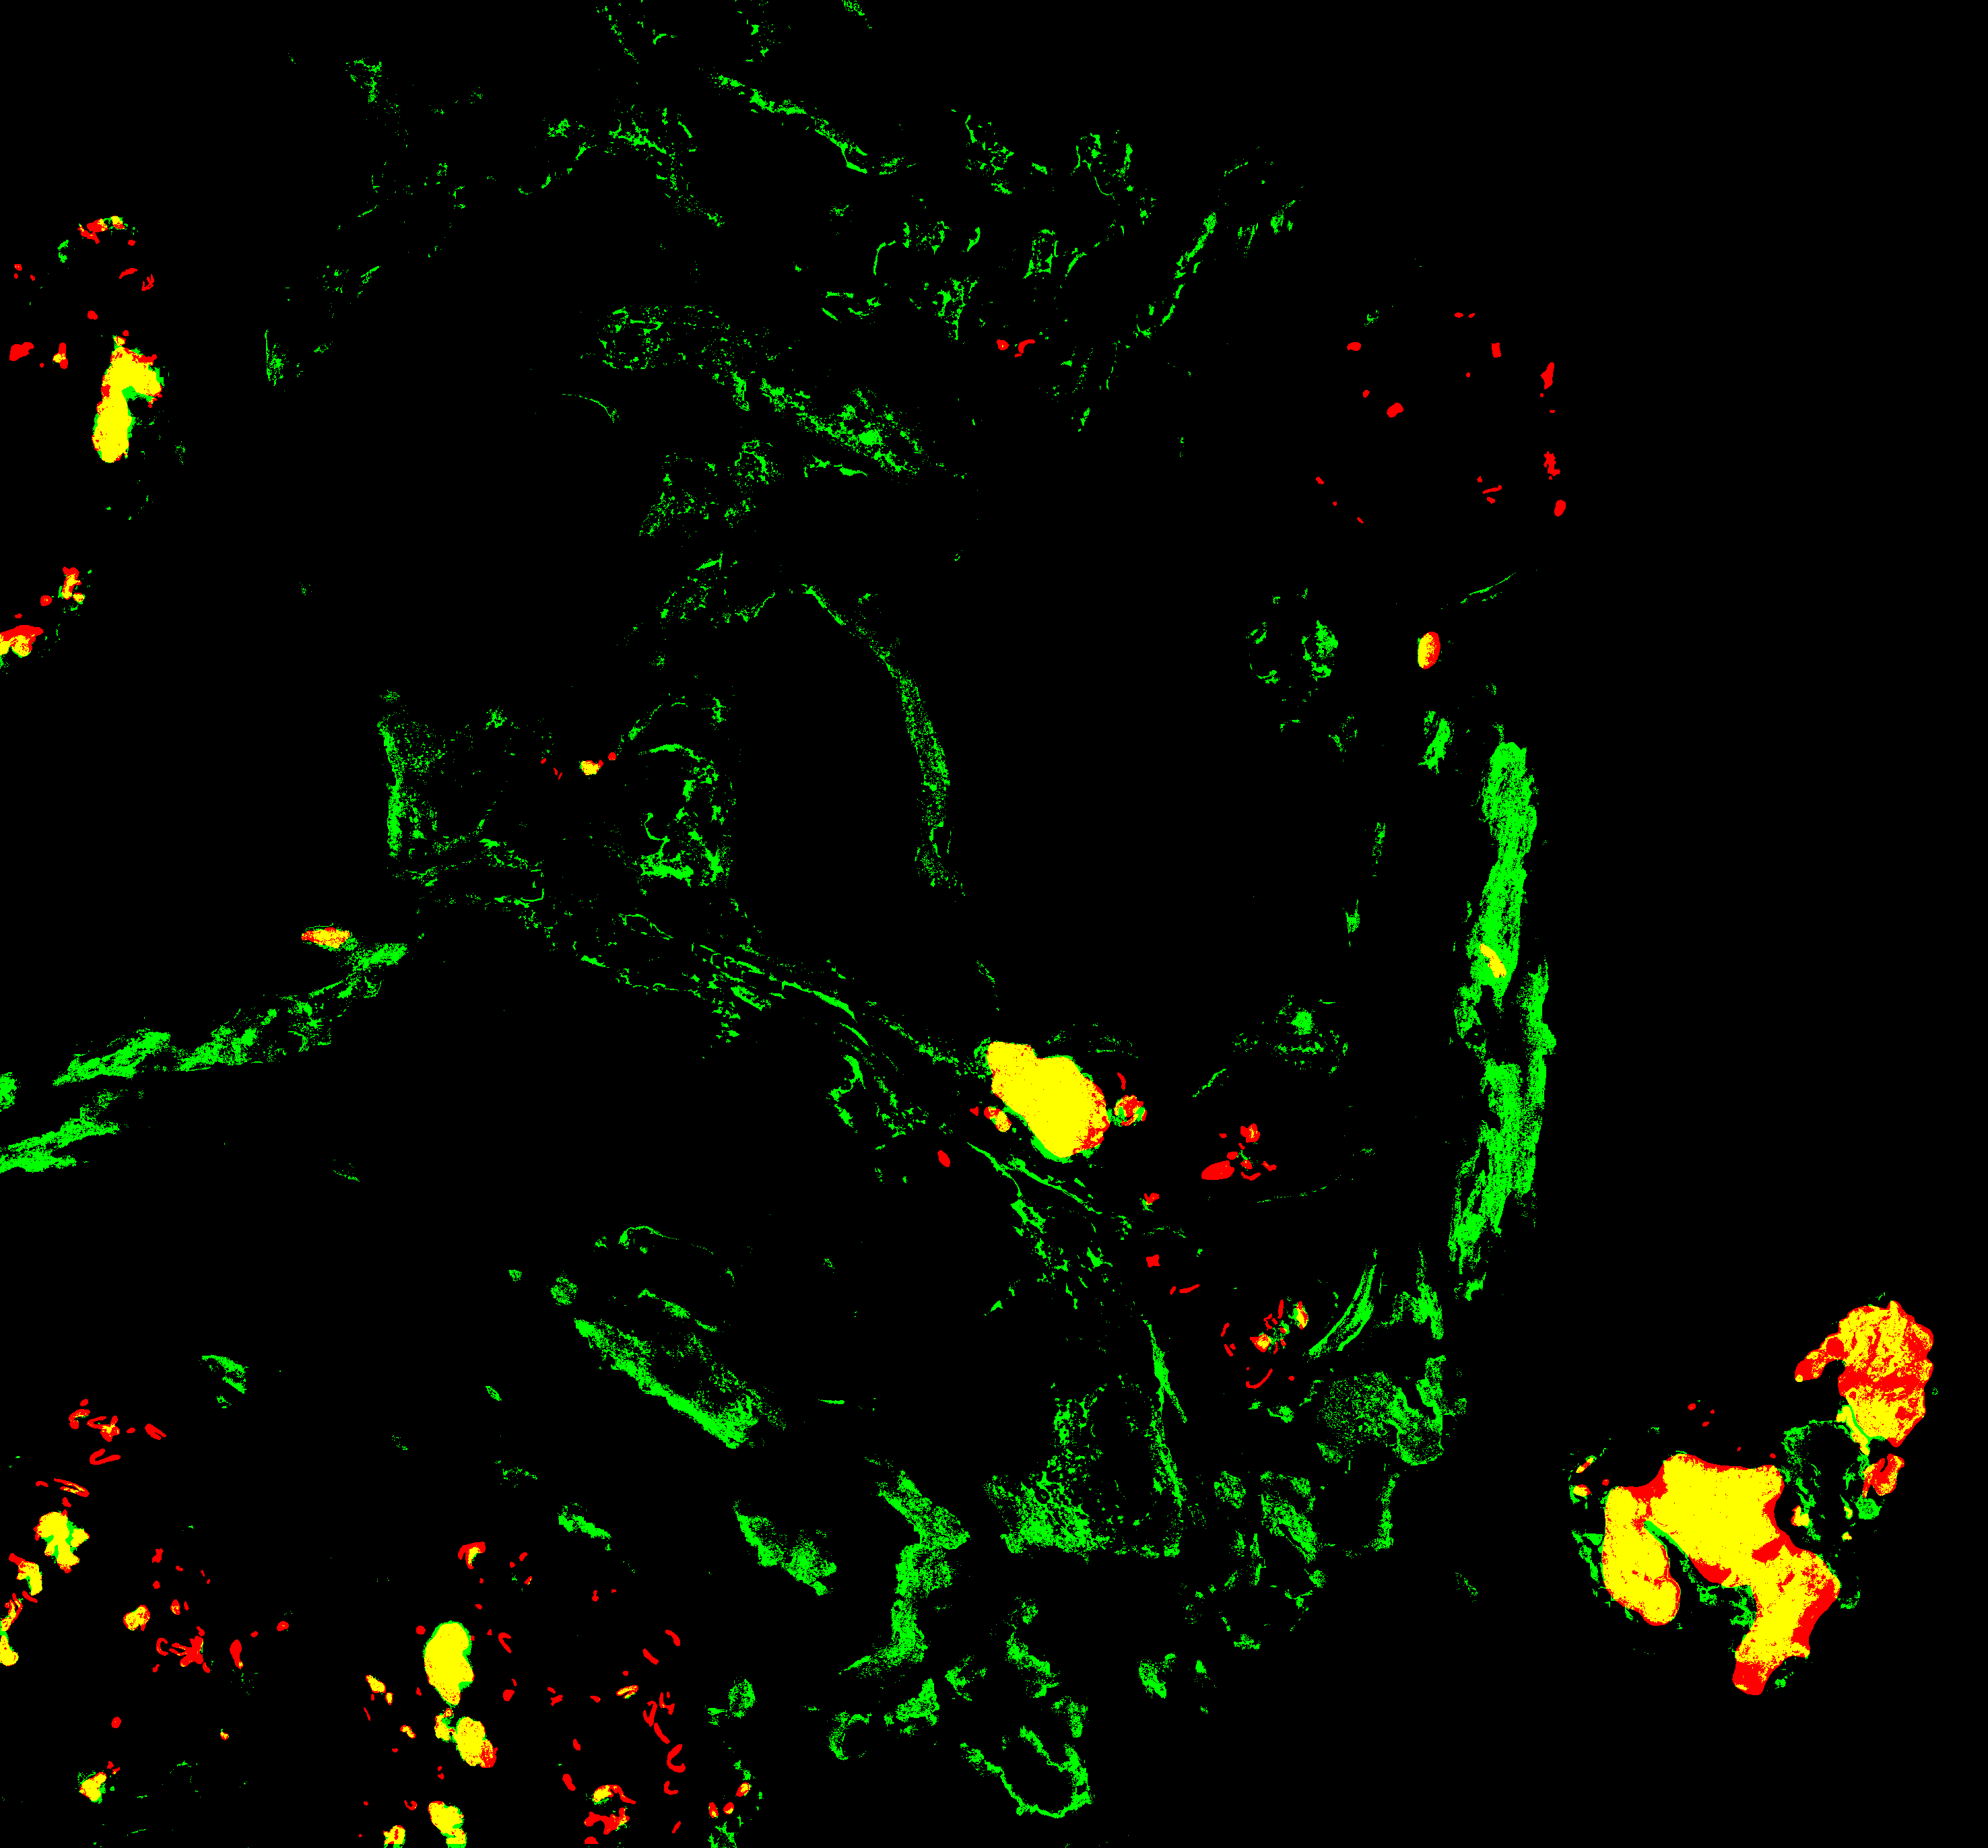

In [97]:
# reshape back to thumb shape
probs_image_comp = np.reshape(output_probs[:, 0], (thumb.shape[:-1]))
# use tissue detector to set background values to zero
filtered_probs_image_comp = np.where(np.logical_not(tissue_mask), 0, probs_image_comp)
cd_fil_prob_im_comp = filtered_probs_image_comp[minrwf:maxrwf, minclf:maxclf]
comp_img = np.dstack((tissue_annot, cd_fil_prob_im_comp>0.1, np.zeros(tissue_annot.shape)))
Image.fromarray(np.array(comp_img*255, dtype=np.uint8))

In [104]:
channels = ["r", "g", "b"]
channels = np.repeat(channels, 24)
sigmas = [0,1,2,4,8,16]
sigmas = np.repeat(sigmas, 4)
sigmas = np.tile(sigmas, 3)
feats = ["gauss", "edge", "texture1", "texture2"]
feats = np.tile(feats, 6*3)
no_edge_mask = np.logical_not(feats == "edge")
small_sigma_mask = sigmas < 8
cols_to_keep_mask = np.logical_and(no_edge_mask, small_sigma_mask)
cols_to_keep_mask

array([ True, False,  True,  True,  True, False,  True,  True,  True,
       False,  True,  True,  True, False,  True,  True, False, False,
       False, False, False, False, False, False,  True, False,  True,
        True,  True, False,  True,  True,  True, False,  True,  True,
        True, False,  True,  True, False, False, False, False, False,
       False, False, False,  True, False,  True,  True,  True, False,
        True,  True,  True, False,  True,  True,  True, False,  True,
        True, False, False, False, False, False, False, False, False])

In [106]:
feats_sample_masked = feats_sample[:, cols_to_keep_mask]
feats_sample_masked.shape

(400000, 36)

In [107]:
from sklearn.ensemble import RandomForestClassifier

clf3 = RandomForestClassifier(n_estimators=50, n_jobs=-1, max_depth=10, max_samples=0.25)
clf3.fit(feats_sample_masked, label_sample.ravel())

RandomForestClassifier(max_depth=10, max_samples=0.25, n_estimators=50,
                       n_jobs=-1)

In [109]:
features_reshape_masked = features_reshape[:, cols_to_keep_mask]
output3 = clf3.predict(features_reshape_masked)
output_probs3 = clf3.predict_proba(features_reshape_masked)

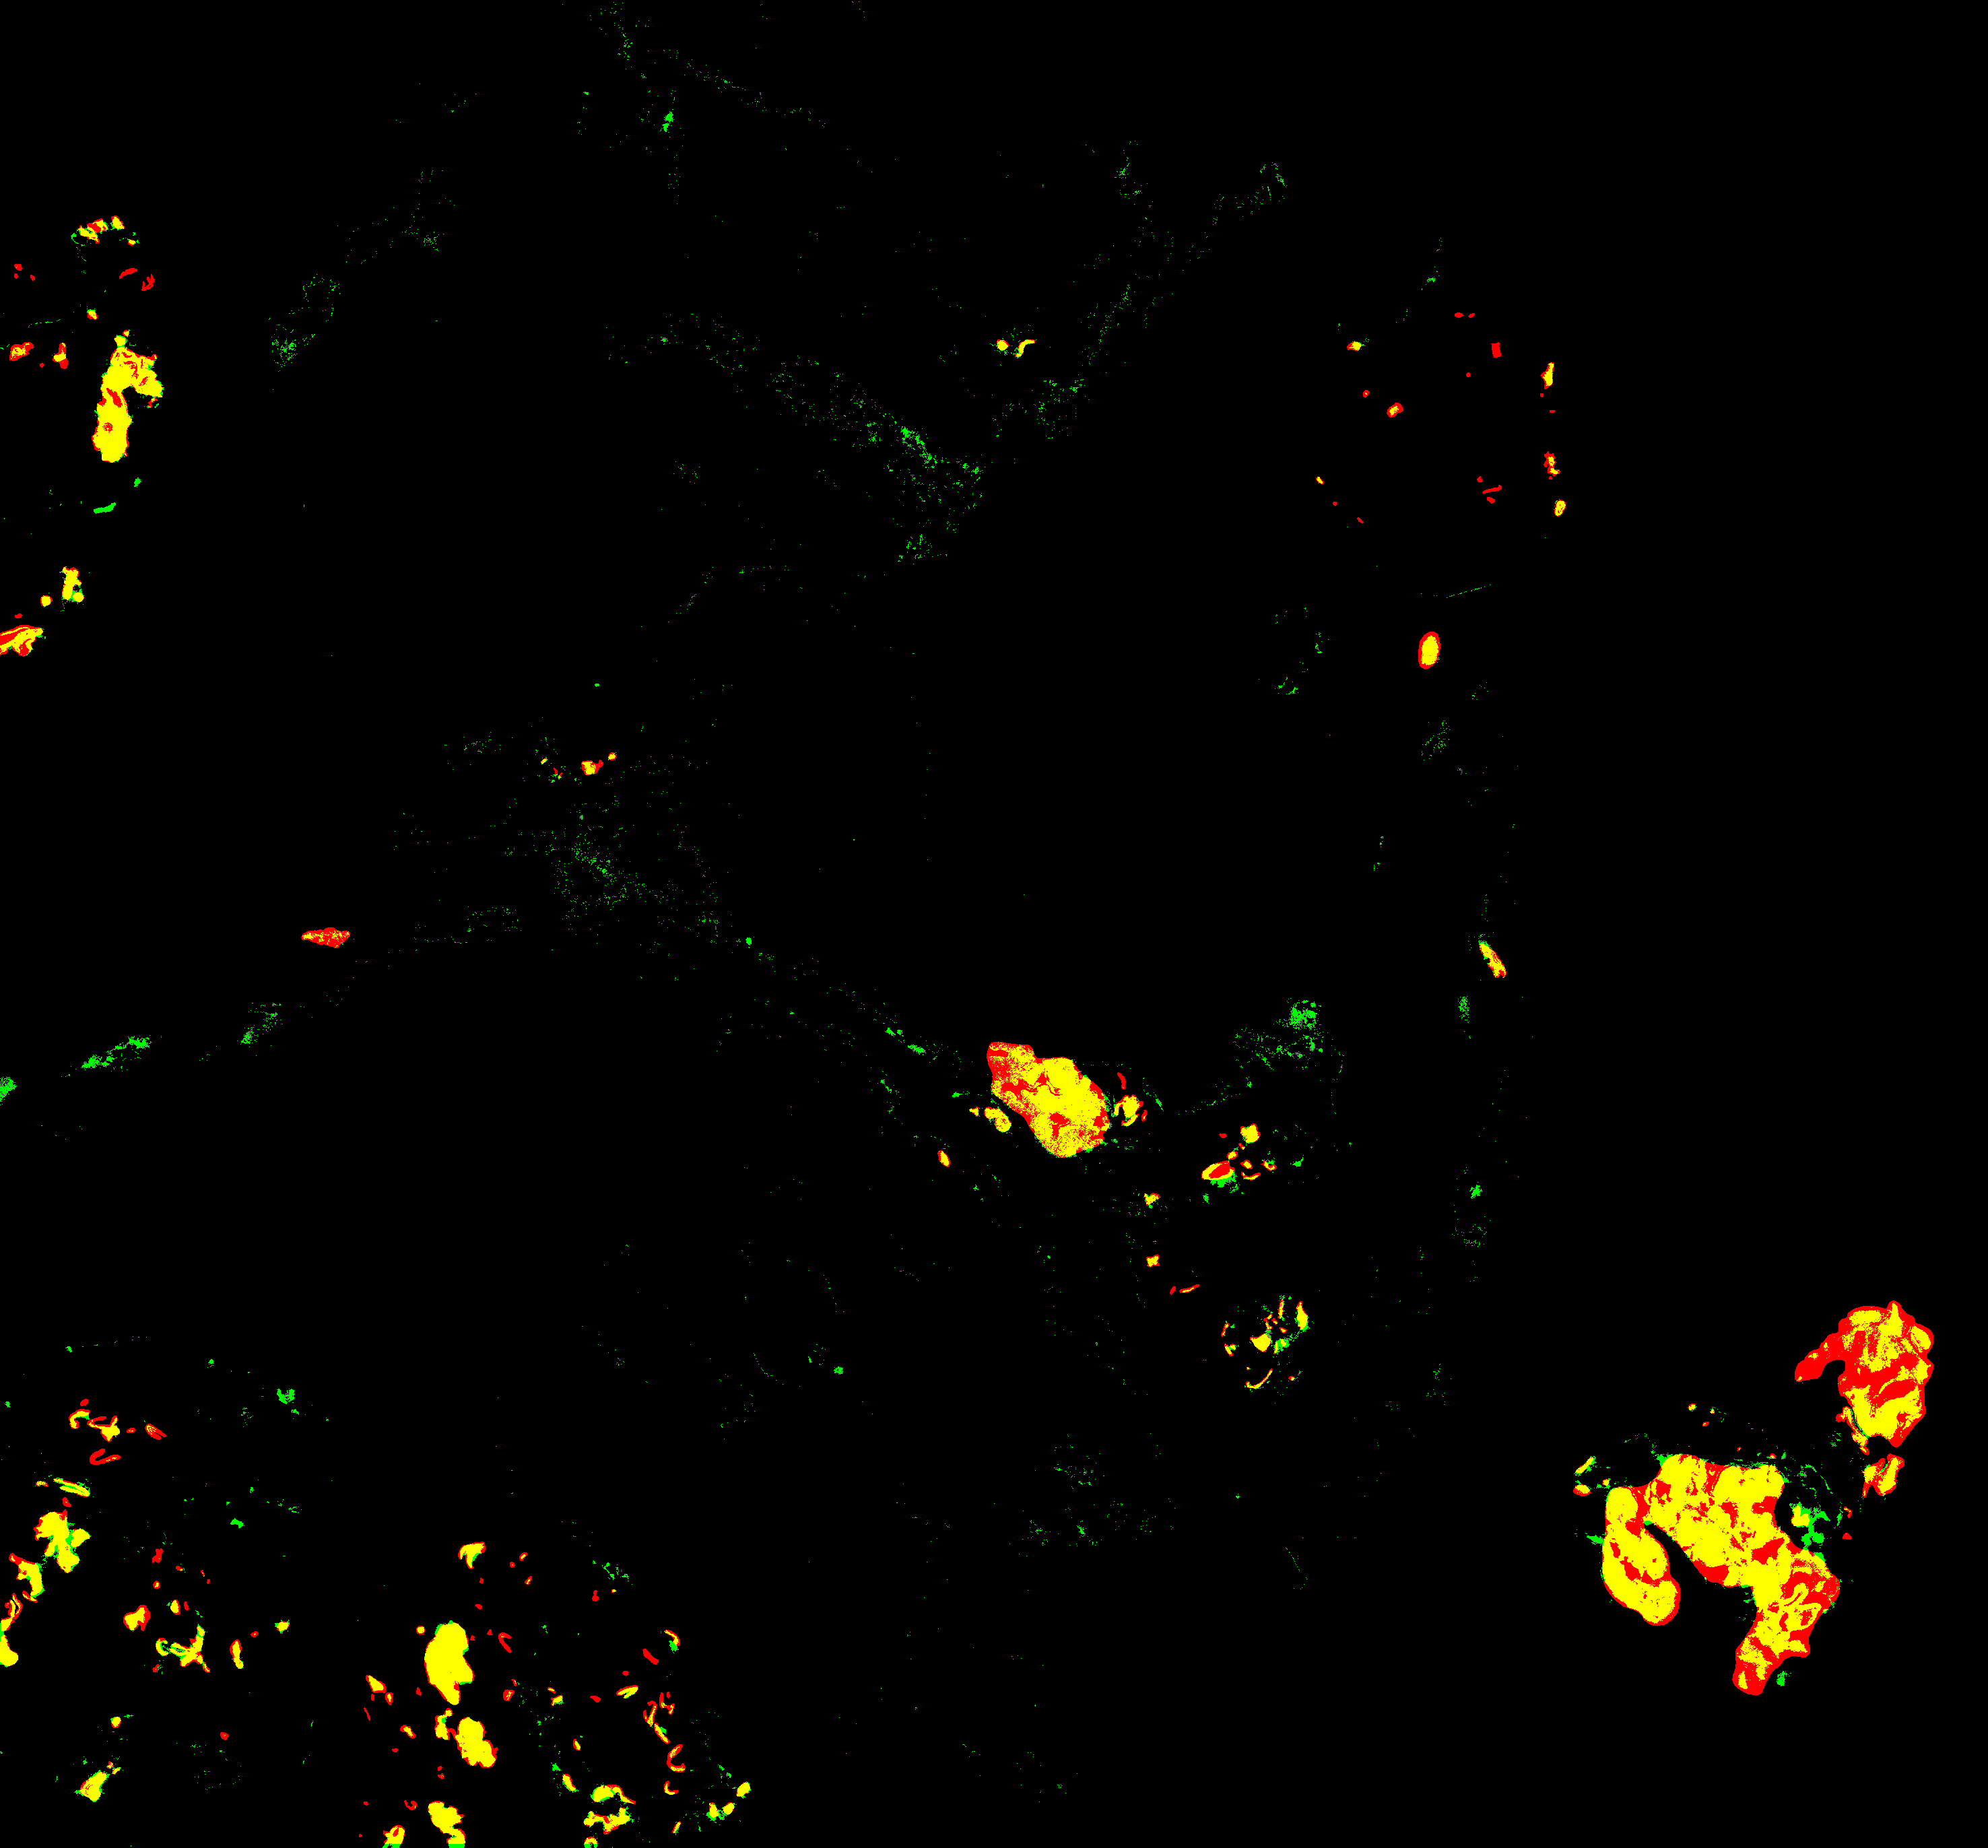

In [111]:
# reshape back to thumb shape
probs_image_comp = np.reshape(output_probs3[:, 0], (thumb.shape[:-1]))
# use tissue detector to set background values to zero
filtered_probs_image_comp = np.where(np.logical_not(tissue_mask), 0, probs_image_comp)
cd_fil_prob_im_comp = filtered_probs_image_comp[minrwf:maxrwf, minclf:maxclf]
comp_img = np.dstack((tissue_annot, cd_fil_prob_im_comp>0.25, np.zeros(tissue_annot.shape)))
Image.fromarray(np.array(comp_img*255, dtype=np.uint8))

In [112]:
channels = ["r", "g", "b"]
channels = np.repeat(channels, 24)
sigmas = [0,1,2,4,8,16]
sigmas = np.repeat(sigmas, 4)
sigmas = np.tile(sigmas, 3)
feats = ["gauss", "edge", "texture1", "texture2"]
feats = np.tile(feats, 6*3)
feat_mask = feats == "gauss"
small_sigma_mask = sigmas < 8
cols_to_keep_mask = np.logical_and(feat_mask, small_sigma_mask)
cols_to_keep_mask

array([ True, False, False, False,  True, False, False, False,  True,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False,  True, False, False, False,  True, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False,  True, False,
       False, False,  True, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False])

In [113]:
feats_sample_masked = feats_sample[:, cols_to_keep_mask]
feats_sample_masked.shape

(400000, 12)

In [114]:
clf4 = RandomForestClassifier(n_estimators=50, n_jobs=-1, max_depth=10, max_samples=0.25)
clf4.fit(feats_sample_masked, label_sample.ravel())

RandomForestClassifier(max_depth=10, max_samples=0.25, n_estimators=50,
                       n_jobs=-1)

In [115]:
features_reshape_masked = features_reshape[:, cols_to_keep_mask]
output4 = clf4.predict(features_reshape_masked)
output_probs4 = clf4.predict_proba(features_reshape_masked)

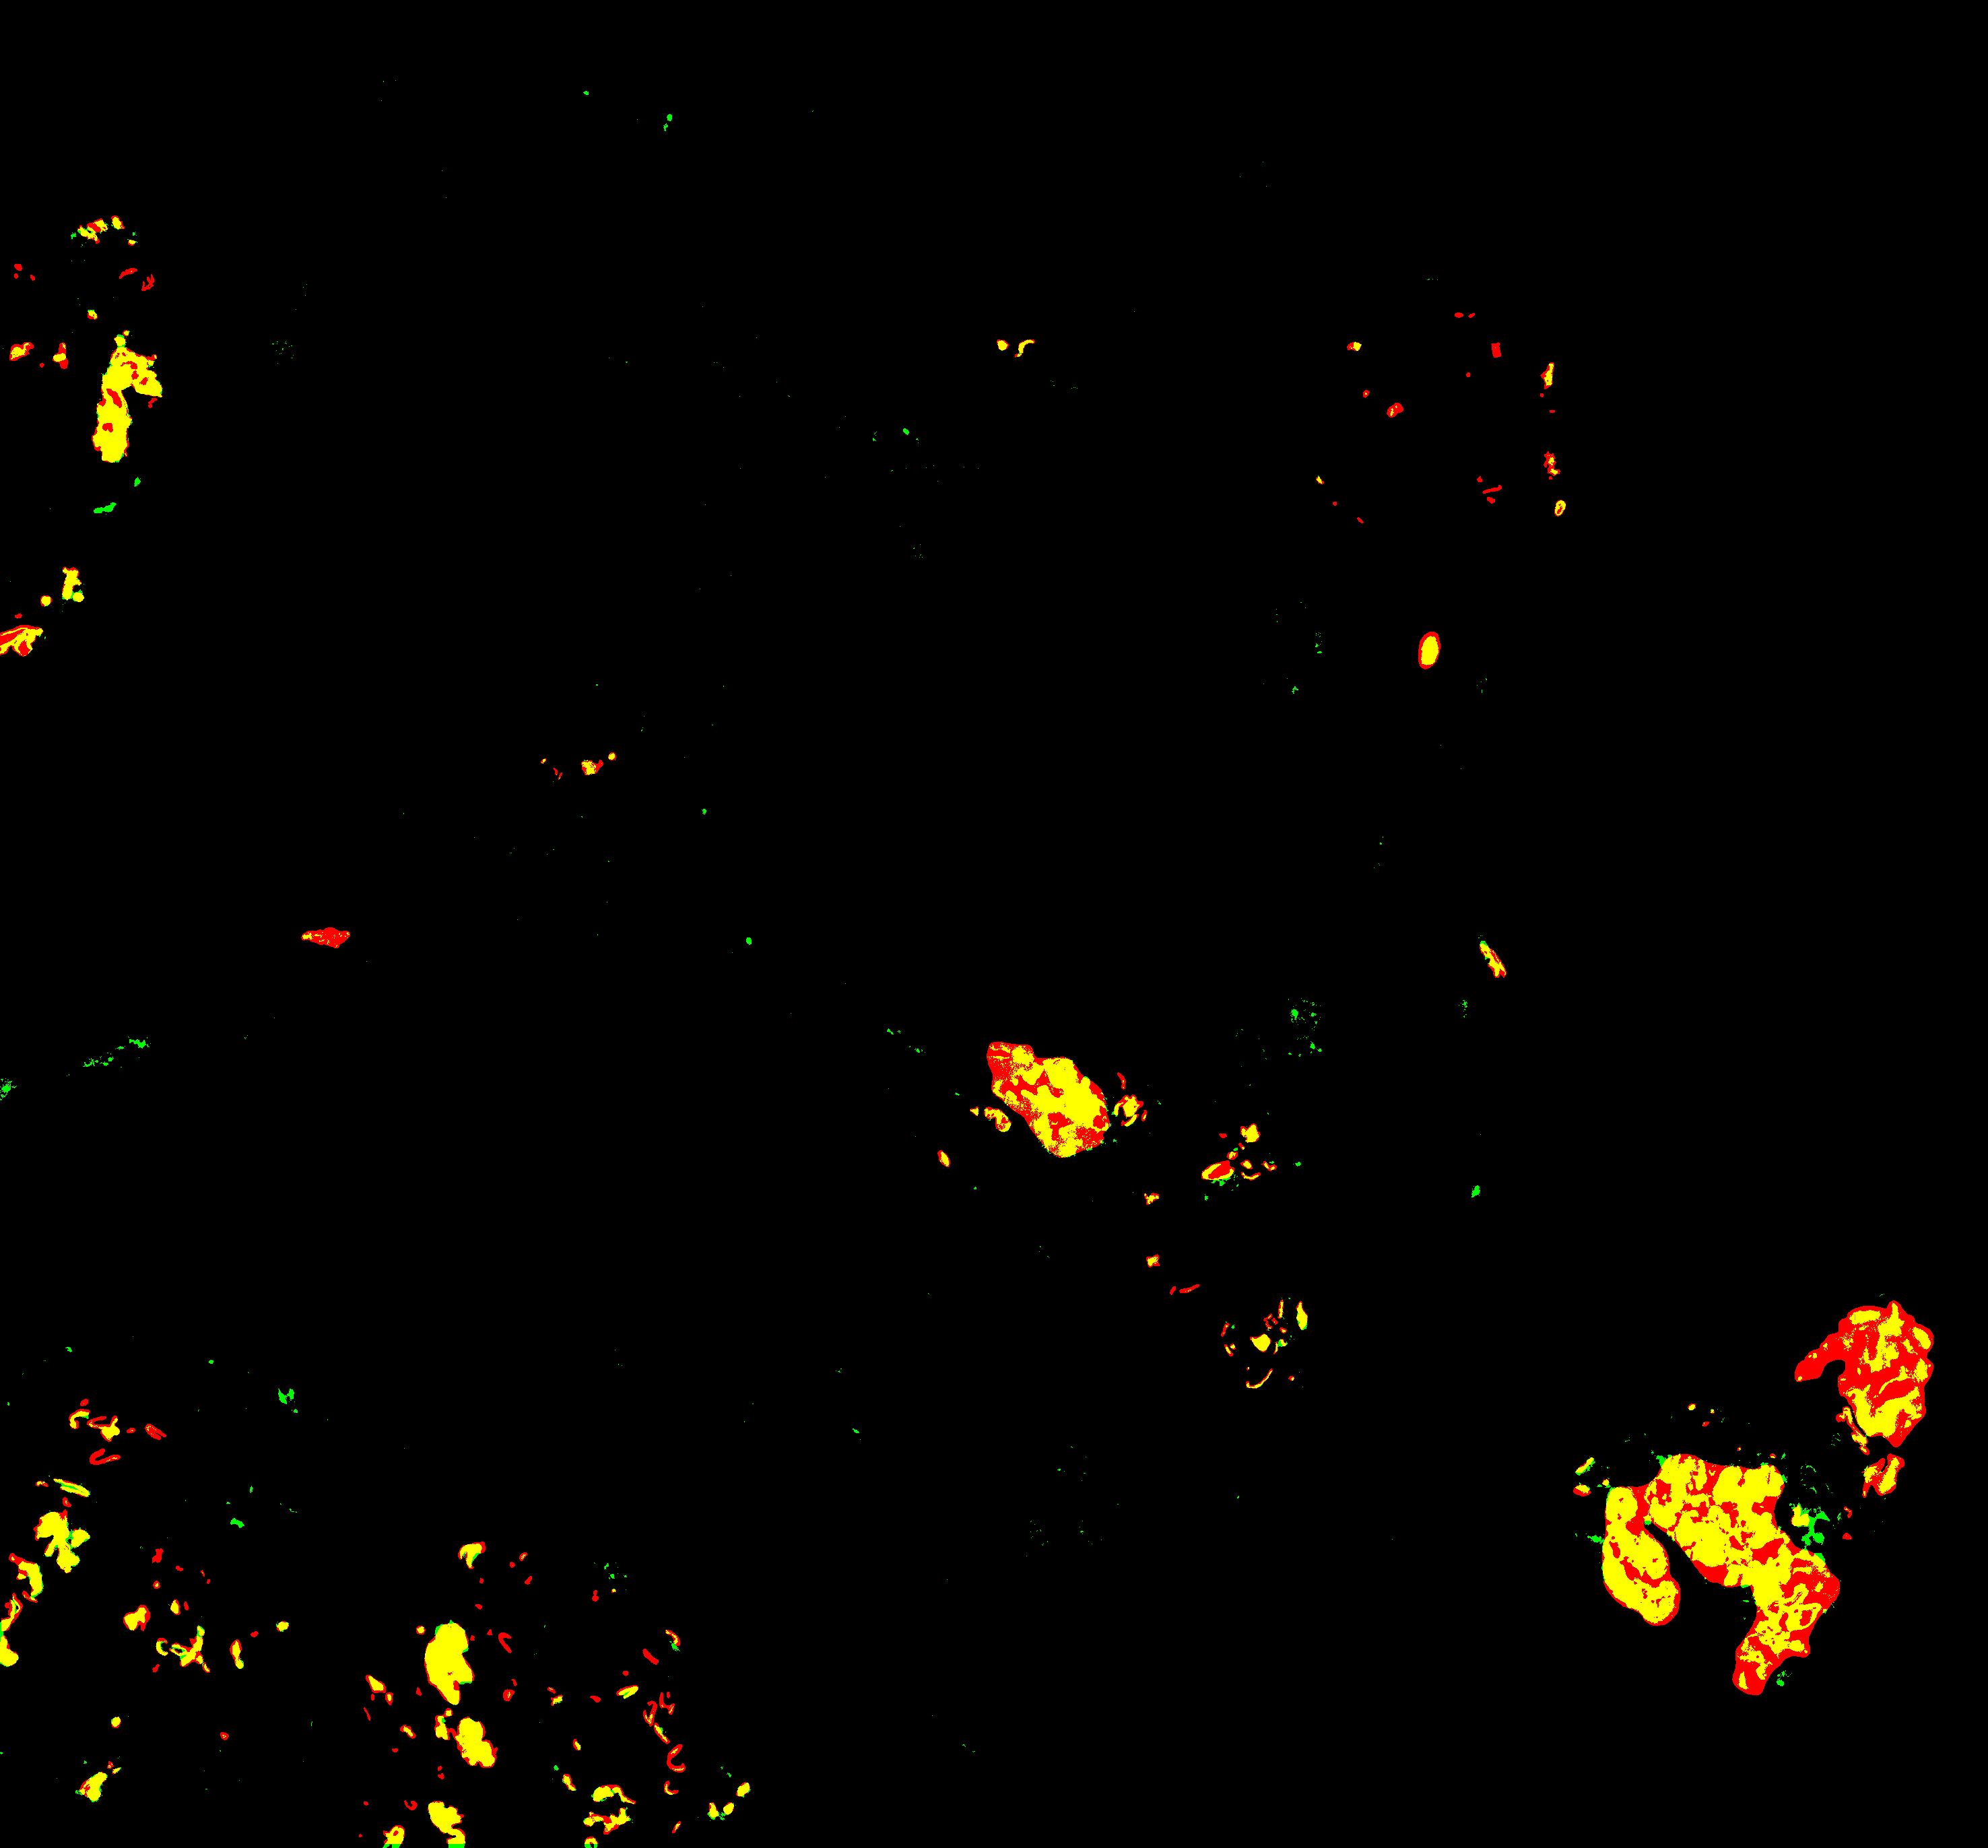

In [116]:
# reshape back to thumb shape
probs_image_comp = np.reshape(output_probs4[:, 0], (thumb.shape[:-1]))
# use tissue detector to set background values to zero
filtered_probs_image_comp = np.where(np.logical_not(tissue_mask), 0, probs_image_comp)
cd_fil_prob_im_comp = filtered_probs_image_comp[minrwf:maxrwf, minclf:maxclf]
comp_img = np.dstack((tissue_annot, cd_fil_prob_im_comp>0.25, np.zeros(tissue_annot.shape)))
Image.fromarray(np.array(comp_img*255, dtype=np.uint8))

In [117]:
channels = ["r", "g", "b"]
channels = np.repeat(channels, 24)
sigmas = [0,1,2,4,8,16]
sigmas = np.repeat(sigmas, 4)
sigmas = np.tile(sigmas, 3)
feats = ["gauss", "edge", "texture1", "texture2"]
feats = np.tile(feats, 6*3)
feat_mask = np.logical_not(feats == "edge")
small_sigma_mask = sigmas < 4
cols_to_keep_mask = np.logical_and(feat_mask, small_sigma_mask)
cols_to_keep_mask

array([ True, False,  True,  True,  True, False,  True,  True,  True,
       False,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False,  True,
        True,  True, False,  True,  True,  True, False,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False,  True,  True,  True, False,
        True,  True,  True, False,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False])

In [118]:
feats_sample_masked = feats_sample[:, cols_to_keep_mask]
feats_sample_masked.shape

(400000, 27)

In [119]:
clf5 = RandomForestClassifier(n_estimators=50, n_jobs=-1, max_depth=10, max_samples=0.25)
clf5.fit(feats_sample_masked, label_sample.ravel())

RandomForestClassifier(max_depth=10, max_samples=0.25, n_estimators=50,
                       n_jobs=-1)

In [120]:
features_reshape_masked = features_reshape[:, cols_to_keep_mask]
output5 = clf5.predict(features_reshape_masked)
output_probs5 = clf5.predict_proba(features_reshape_masked)

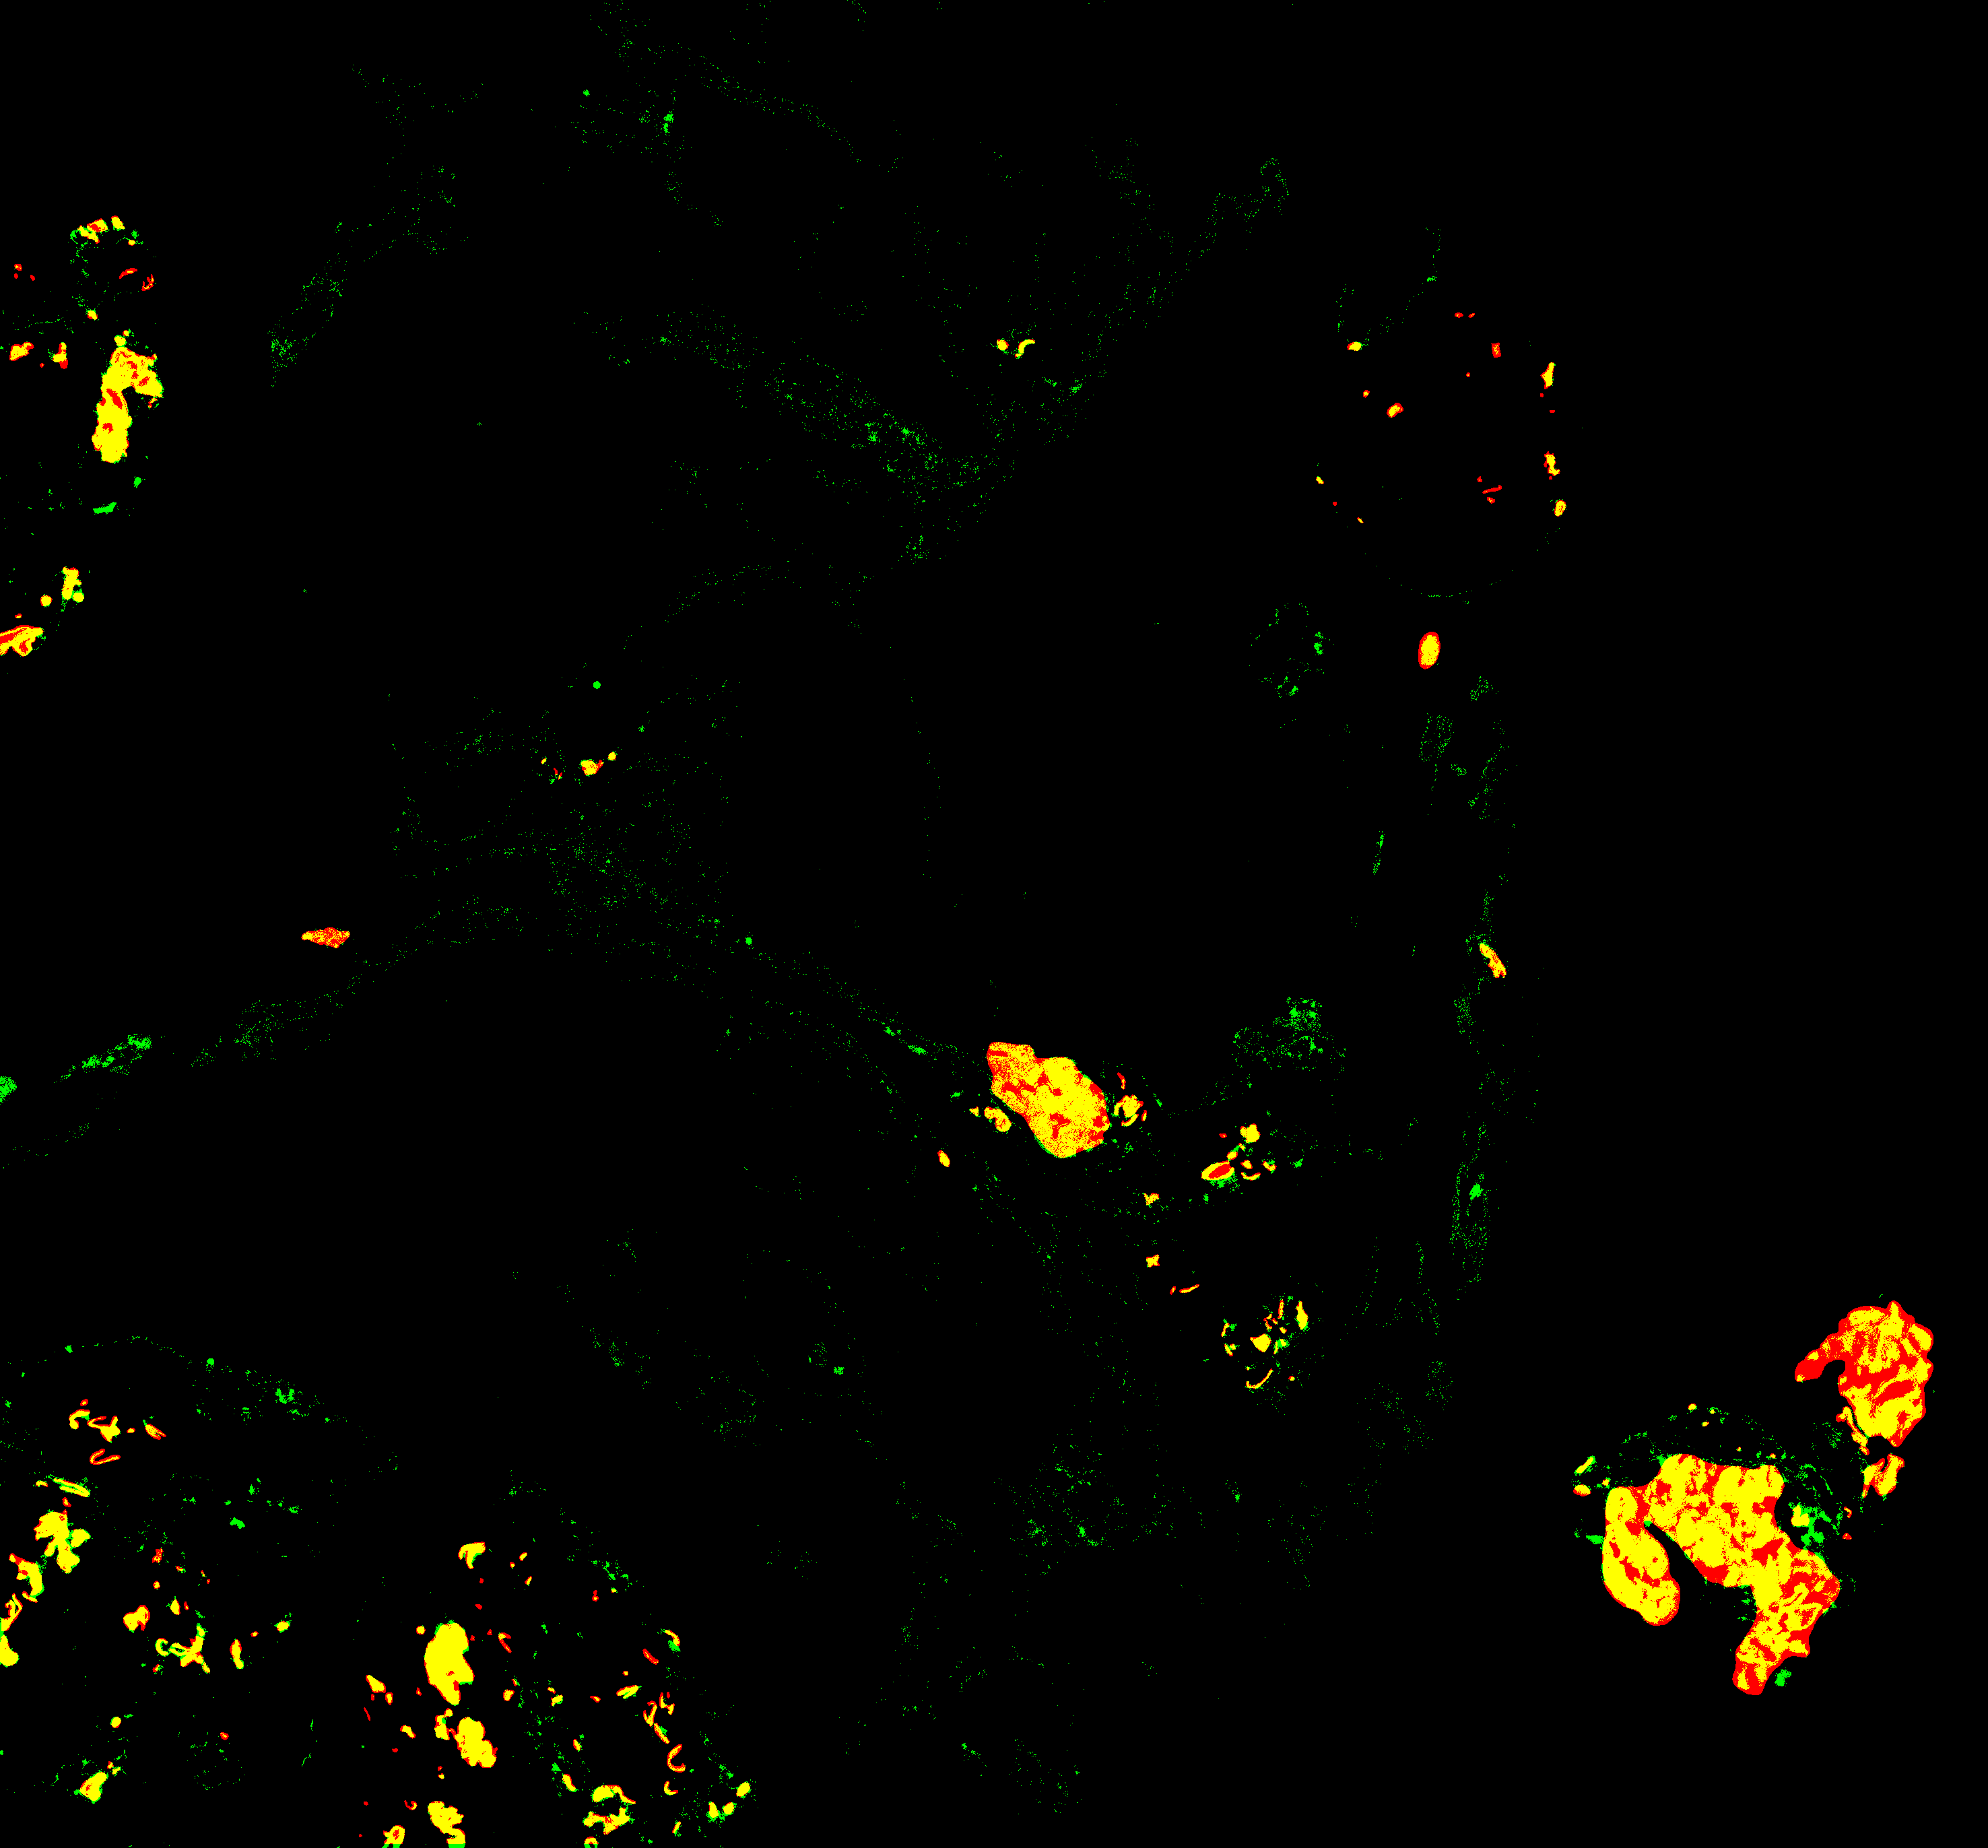

In [121]:
# reshape back to thumb shape
probs_image_comp = np.reshape(output_probs5[:, 0], (thumb.shape[:-1]))
# use tissue detector to set background values to zero
filtered_probs_image_comp = np.where(np.logical_not(tissue_mask), 0, probs_image_comp)
cd_fil_prob_im_comp = filtered_probs_image_comp[minrwf:maxrwf, minclf:maxclf]
comp_img = np.dstack((tissue_annot, cd_fil_prob_im_comp>0.25, np.zeros(tissue_annot.shape)))
Image.fromarray(np.array(comp_img*255, dtype=np.uint8))

In [122]:
clf6 = MLPClassifier(hidden_layer_sizes=[50], max_iter=500, verbose=True)
clf6.fit(feats_sample_masked, label_sample.ravel())

Iteration 1, loss = 0.94570397
Iteration 2, loss = 0.81212359
Iteration 3, loss = 0.78737641
Iteration 4, loss = 0.77267955
Iteration 5, loss = 0.76238059
Iteration 6, loss = 0.75409914
Iteration 7, loss = 0.74762398
Iteration 8, loss = 0.74190730
Iteration 9, loss = 0.73727279
Iteration 10, loss = 0.73268810
Iteration 11, loss = 0.72849421
Iteration 12, loss = 0.72530937
Iteration 13, loss = 0.72245088
Iteration 14, loss = 0.71905789
Iteration 15, loss = 0.71707367
Iteration 16, loss = 0.71479547
Iteration 17, loss = 0.71313717
Iteration 18, loss = 0.71122336
Iteration 19, loss = 0.70993389
Iteration 20, loss = 0.70790375
Iteration 21, loss = 0.70633119
Iteration 22, loss = 0.70500592
Iteration 23, loss = 0.70414734
Iteration 24, loss = 0.70274109
Iteration 25, loss = 0.70132594
Iteration 26, loss = 0.70043328
Iteration 27, loss = 0.69935319
Iteration 28, loss = 0.69813865
Iteration 29, loss = 0.69746443
Iteration 30, loss = 0.69625295
Iteration 31, loss = 0.69562425
Iteration 32, los

MLPClassifier(hidden_layer_sizes=[50], max_iter=500, verbose=True)

In [123]:
output6 = clf6.predict(features_reshape_masked)
output_probs6 = clf6.predict_proba(features_reshape_masked)

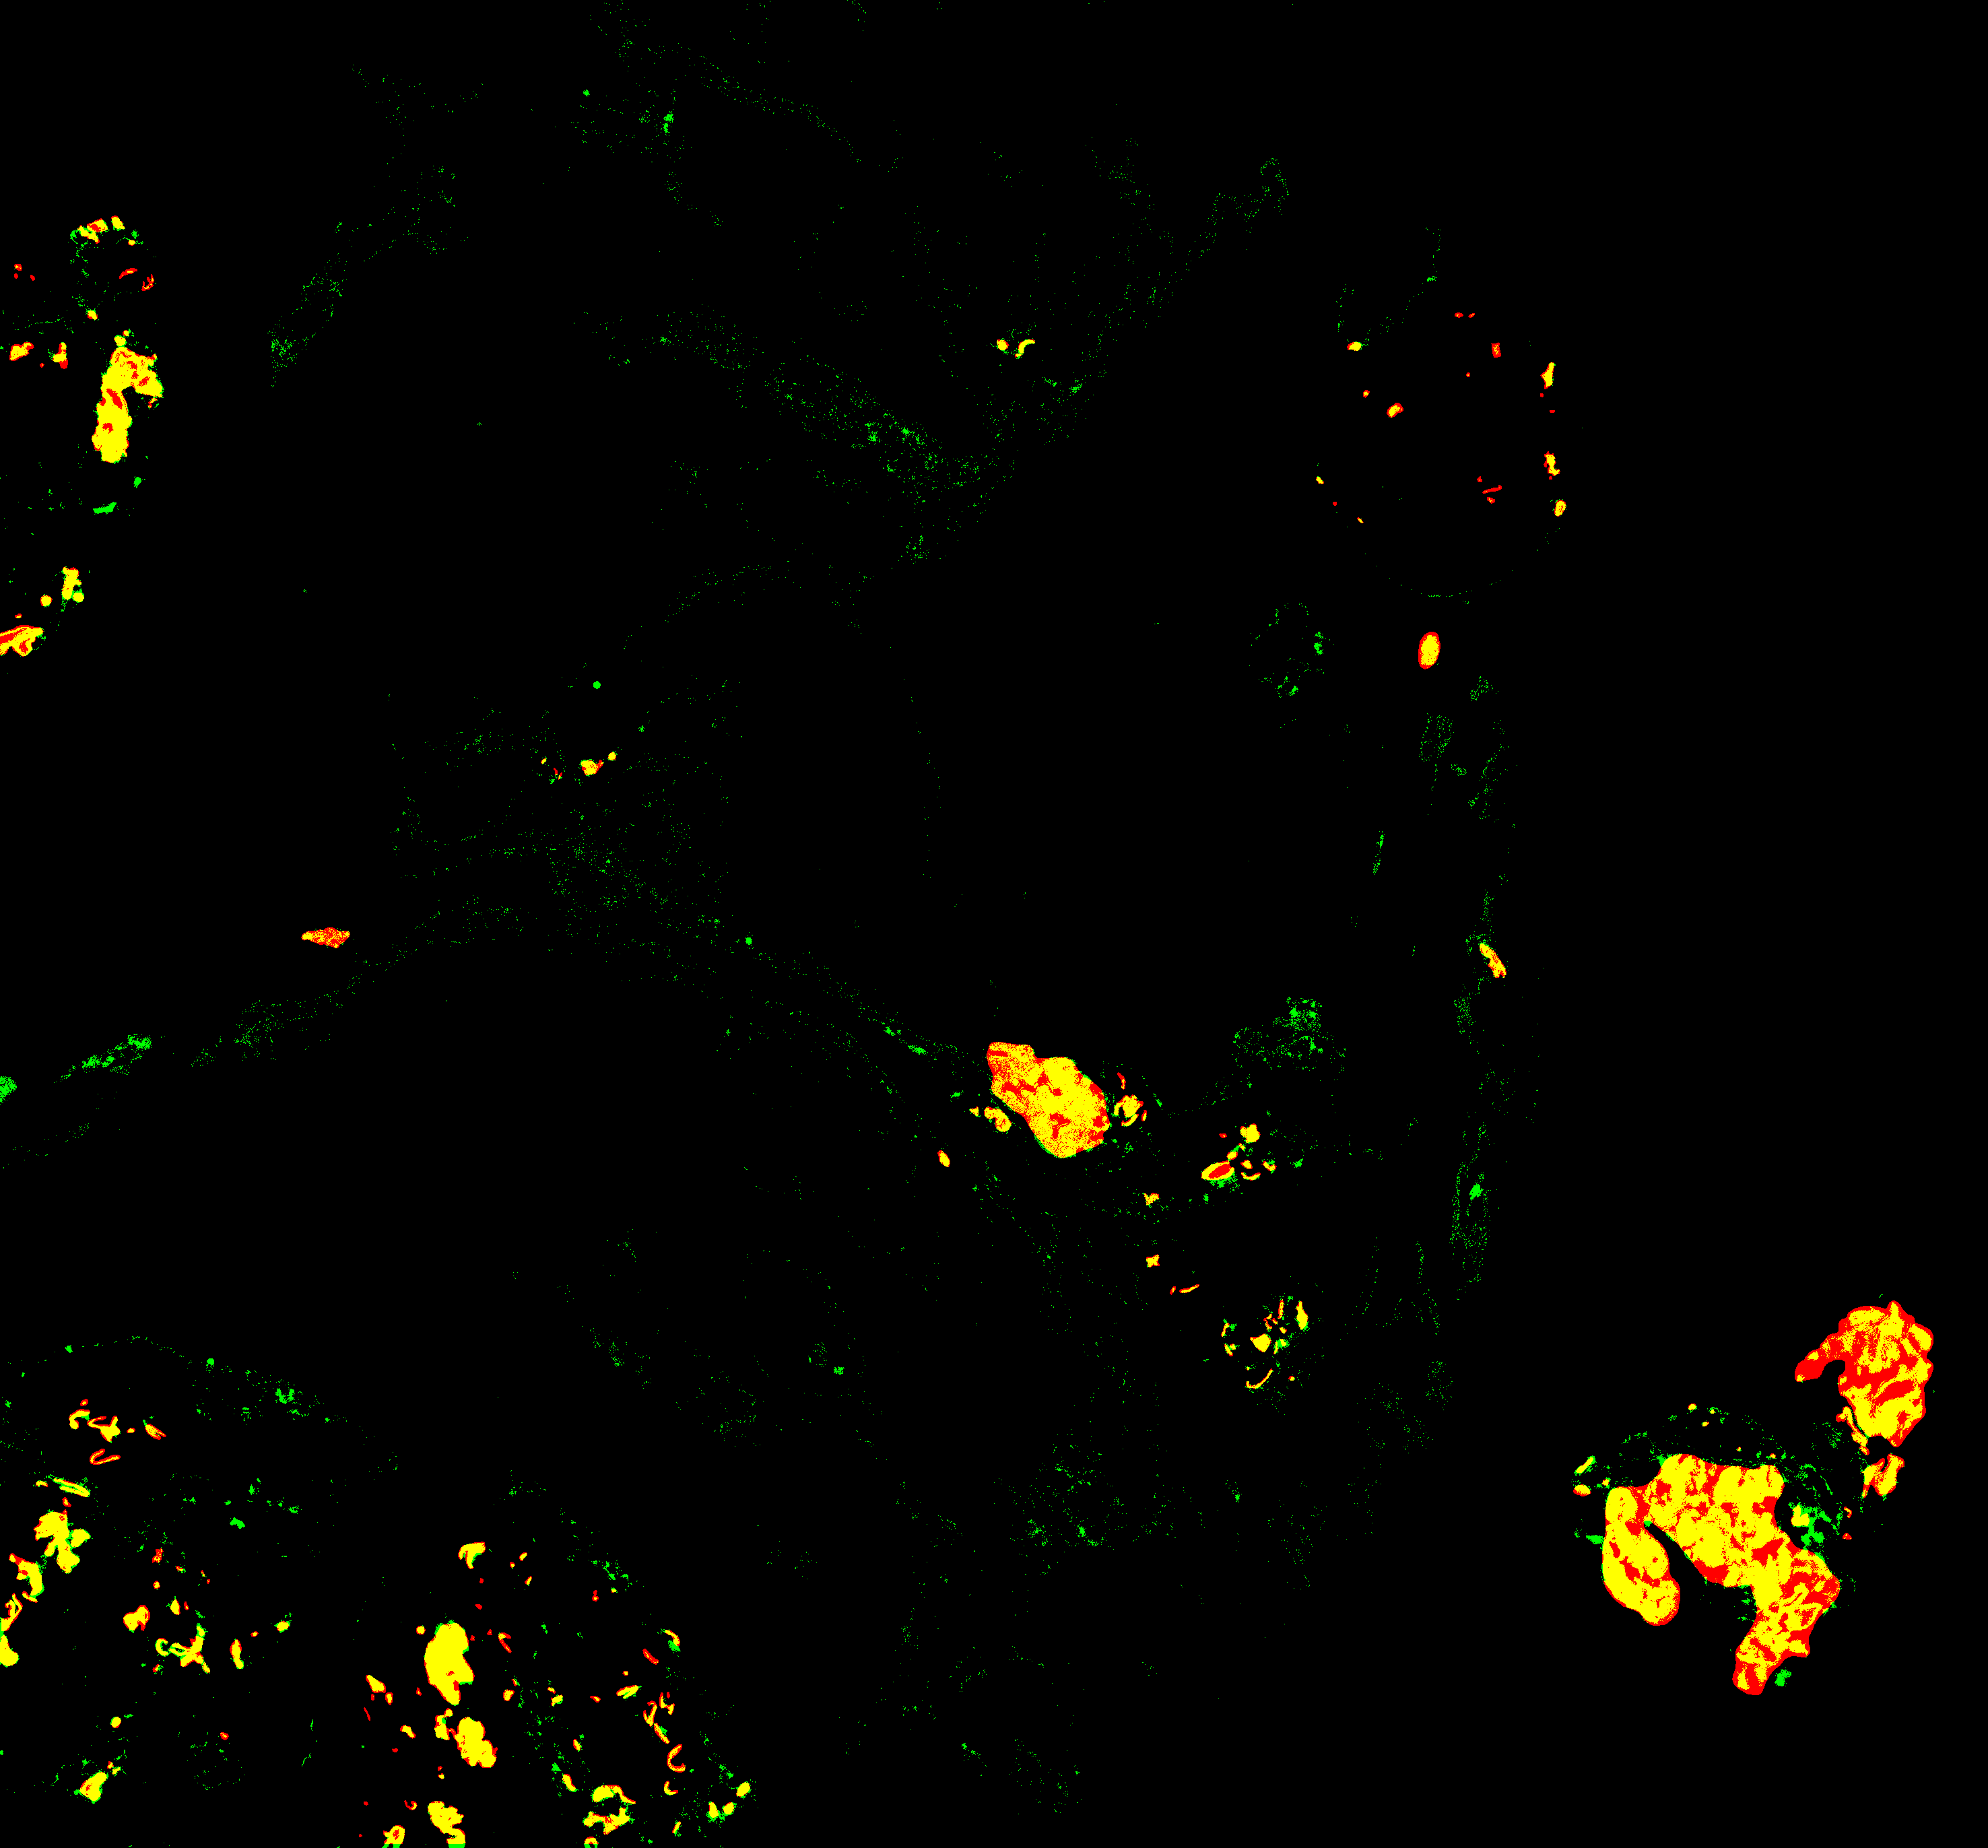

In [159]:
# reshape back to thumb shape
probs_image_comp = np.reshape(output_probs5[:, 0], (thumb.shape[:-1]))
# use tissue detector to set background values to zero
filtered_probs_image_comp = np.where(np.logical_not(tissue_mask), 0, probs_image_comp)
cd_fil_prob_im_comp = filtered_probs_image_comp[minrwf:maxrwf, minclf:maxclf]
comp_img = np.dstack((tissue_annot, cd_fil_prob_im_comp>0.25, np.zeros(tissue_annot.shape)))
Image.fromarray(np.array(comp_img*255, dtype=np.uint8))

In [157]:
def predict_images2(clf, experiment_root, pixel_feature_detector, morph=False) -> None:
    # set values
    output_level = 7

    # read in validation dataset
    dset = bloodm.validation()

    # read in slides and for extracting features
    thumbz, annotz = get_slides_annots(dset, feature_level, default_label="background")
    filtered_thumbz = set_background_to_white(thumbz, tissue_detector)

    # read in slides and annotations for plotting and calculating results
    thumbz_out, annotz_out = get_slides_annots(dset, output_level, default_label="background")
    filtered_thumbz_out = set_background_to_white(thumbz_out, tissue_detector)
    annot_areaz = get_annot_areas(dset, output_level)

    # settings for pooling from feature level to output level
    patch_level = 0
    patch_size = 2**output_level
    stride = patch_size
    scale_factor = 2 ** (feature_level - patch_level)
    kernel_size = int(patch_size / scale_factor)
    label_level_stride = int(stride / scale_factor)

    # create blank confusion matrices
    confusion_matrix_2class = np.zeros((len(thumbz), 4))
    confusion_matrix_3class = np.zeros((len(thumbz), 9))

    for idx, thumb in enumerate(filtered_thumbz):
        print(idx, "of", len(filtered_thumbz))
        # get features from pixel feature detector (shape is thumb rows, thumb columns, nfeatures)
        features = pixel_feature_detector(thumb)
        # flatten so shape is 2d (thumb rows * thumb columns, nfeatures)
        features_reshape = features.reshape(-1, features.shape[-1])
        
        # predict from features
        output = clf.predict(features_reshape)
        
        # reshape back to thumb shape
        labels_image = np.reshape(output, (thumb.shape[:-1]))

        # use tissue detector to set background values to zero
        tissue_mask = tissue_detector(thumb)
        filtered_labels_image = np.where(np.logical_not(tissue_mask), 0, labels_image)

        # change to output size by pooling values 
        output_labels = pool_blood_mucus(filtered_labels_image, kernel_size, label_level_stride, 0)
        # output labels, background = 0, tissue = 1, blood or mucus = 2

        # get output thumbnail
        thumb_out = thumbz_out[idx]
        filtered_thumb_out = filtered_thumbz_out[idx]
        # adjust size sometimes pixel size off by one ### HACK
        if thumb_out.shape[0:2] != output_labels.shape:
            output_labels = output_labels[0:thumb_out.shape[0], 0:thumb_out.shape[1]]

        # create output image with just tissue
        tissue_output = np.where(np.expand_dims(output_labels, axis=-1) == 1, filtered_thumb_out, 255)
        # create output image with just blood mucus
        bloodm_output = np.where(np.expand_dims(output_labels, axis=-1) == 2, filtered_thumb_out, 255)

        # colour annotations for output
        annot_out = annotz_out[idx]
        annot_out = np.expand_dims(annot_out, axis=-1)
        annot_out_cl = np.dstack((annot_out, annot_out, annot_out))
        tissue = np.array([255,255,255]).reshape((1,1,3))
        blood = np.array([255,0,0]).reshape((1,1,3))
        mucus = np.array([255,208,182]).reshape((1,1,3))
        blmuc = np.array([186,85,211]).reshape((1,1,3))
        annot_out_cl = np.where(annot_out == 1, tissue, annot_out_cl)
        annot_out_cl = np.where(annot_out == 2, blood, annot_out_cl)
        annot_out_cl = np.where(annot_out == 3, mucus, annot_out_cl)
        annot_out_cl = np.where(annot_out == 4, blmuc, annot_out_cl)

        # output images, convert to PIL and save
        filename = str(idx) + '.png'
        # output thumbnail unprocessed
        thumb_out_image = Image.fromarray(np.array(thumb_out, dtype=np.uint8))
        # output thumbnail with background removed
        filtered_thumb_out_image = Image.fromarray(np.array(filtered_thumb_out, dtype=np.uint8))
        # output pathologist annotations
        annot_out_image = Image.fromarray(np.array(annot_out_cl, dtype=np.uint8))
        # output stuff removed by blood and mucus detector
        bloodm_image = Image.fromarray(np.array(bloodm_output, dtype=np.uint8))
        # output remaining tissue
        tissue_image = Image.fromarray(np.array(tissue_output, dtype=np.uint8))
        # output predicted labels
        output_labels_image = Image.fromarray(np.array(output_labels*100, dtype=np.uint8))

        # create and output mosaic of outputs
        top_row = get_concat_h(get_concat_h(thumb_out_image, filtered_thumb_out_image), annot_out_image)
        low_row = get_concat_h(get_concat_h(bloodm_image, tissue_image), output_labels_image)
        get_concat_v(top_row, low_row).save(experiment_root / filename)

        # calculate numeric results        
        # get area which is fuly annotated and calculate position
        annot_area = annot_areaz[idx]
        pixvals = np.where(annot_area > 0)
        minrw = min(pixvals[0])
        maxrw = max(pixvals[0])+1
        mincl = min(pixvals[1])
        maxcl = max(pixvals[1])+1

        # cutdown thumbnail to just annotated_area
        cd_thumb = thumb_out[minrw:maxrw, mincl:maxcl, :]
        # cutdown thumbnail with background removed to just annotated area
        cd_fil_thumb = filtered_thumb_out[minrw:maxrw, mincl:maxcl, :]
        # cutdown pathologist annotation thumbnail to just annotated area
        cd_annots = annot_out[minrw:maxrw, mincl:maxcl, 0]
        # cut down stuff removed by blood mucus detector to just annotated area
        cd_bloodm = bloodm_output[minrw:maxrw, mincl:maxcl, :]
        # cut down remaining tissue to annotated area
        cd_tissue = tissue_output[minrw:maxrw, mincl:maxcl, :]
        # cutdown predicted labels thumbnail to just annotated area
        cd_preds = output_labels[minrw:maxrw, mincl:maxcl]

        # change labels of pathologist annotation so blood and mucus classes as grouped together
        cd_annots = np.where(cd_annots > 1, 2, cd_annots)
        
        if morph:
            # fill holes and expand mask for tissue
            tiss_mask = cd_preds == 1
            closing_trans = SizedClosingTransform(level_in=output_level)
            fill_holes = FillHolesTransform(level_in=output_level)
            tiss_mask = fill_holes(tiss_mask)
            tiss_mask = closing_trans(tiss_mask)
            cd_preds = np.where(tiss_mask, tiss_mask, cd_preds)
        

        # calculate confusion matrices for this slide output is 1d vector
        # 3 class background, blood_mucus, tissue
        cm3cl = calc_confusion_mat_3class(cd_annots, cd_preds)
        # 2 class tissue, not tissue
        cm2cl = calc_confusion_mat_2class(cd_annots, cd_preds)

        # add to array of confusion matrices for all slides
        confusion_matrix_3class[idx, :] = cm3cl
        confusion_matrix_2class[idx, :] = cm2cl

        # output cutdown images, convert to PIL and save
        filename_cd = str(idx) + '_cd.png'
        # output thumbnail unprocessed
        cd_thumb_image = Image.fromarray(np.array(cd_thumb, dtype=np.uint8))
        # output thumbnail with background removed
        cd_filthumb_image = Image.fromarray(np.array(cd_fil_thumb, dtype=np.uint8))
        # output pathologist annotations
        cd_annot_image = Image.fromarray(np.array(cd_annots*100, dtype=np.uint8))
        # output stuff removed by blood and mucus detector
        cd_bloodm_image = Image.fromarray(np.array(cd_bloodm, dtype=np.uint8))
        # output remaining tissue
        cd_tissue_image = Image.fromarray(np.array(cd_tissue, dtype=np.uint8))
        # output predicted labels
        cd_preds_image = Image.fromarray(np.array(cd_preds*100, dtype=np.uint8))

        # create and output mosaic of outputs
        top_row_cd = get_concat_h(get_concat_h(cd_thumb_image, cd_filthumb_image), cd_annot_image)
        low_row_cd = get_concat_h(get_concat_h(cd_bloodm_image, cd_tissue_image), cd_preds_image)
        get_concat_v(top_row_cd, low_row_cd).save(experiment_root / filename_cd)

    # sum all rows to get total for all slides
    cm_3class_all = np.sum(confusion_matrix_3class, axis=0)
    save_confusion_mat(cm_3class_all, experiment_root, experiment_name)
    cm_2class_all = np.sum(confusion_matrix_2class, axis=0)
    save_confusion_mat(cm_2class_all, experiment_root, experiment_name)

0 of 6
1 of 6
2 of 6
3 of 6
4 of 6
5 of 6


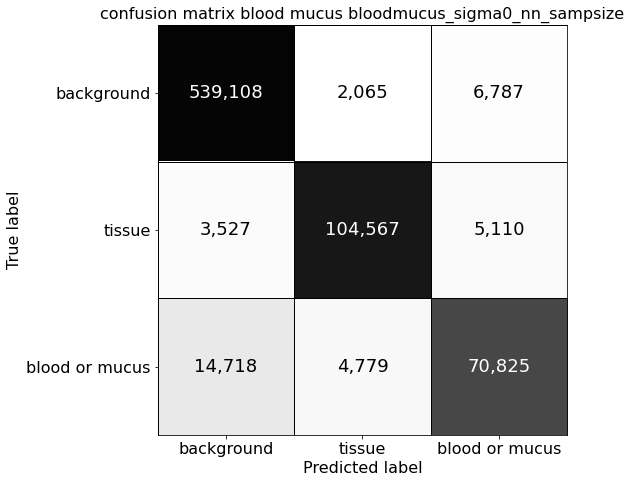

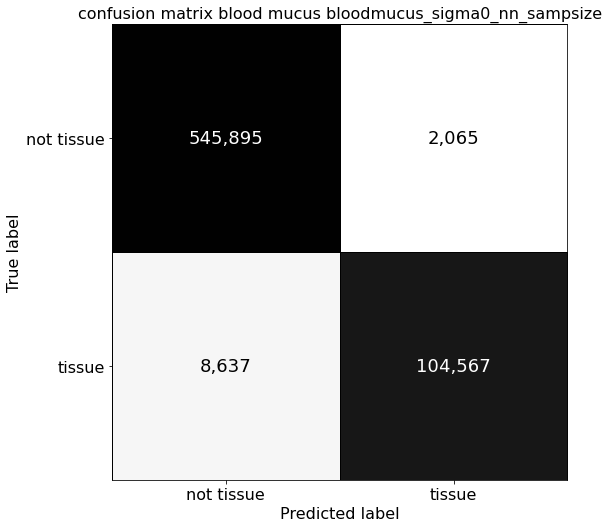

In [152]:
sub_exp_root5 = experiment_root / "mask_cols"
sub_exp_root5.mkdir(parents=True, exist_ok=True)

features_list = [TextureFeature()]
pixel_feature_detector2 = PixelFeatureDetector(features_list=features_list, sigma_min = 1, sigma_max = 2, raw=True)

predict_images2(clf5, sub_exp_root5, pixel_feature_detector2)

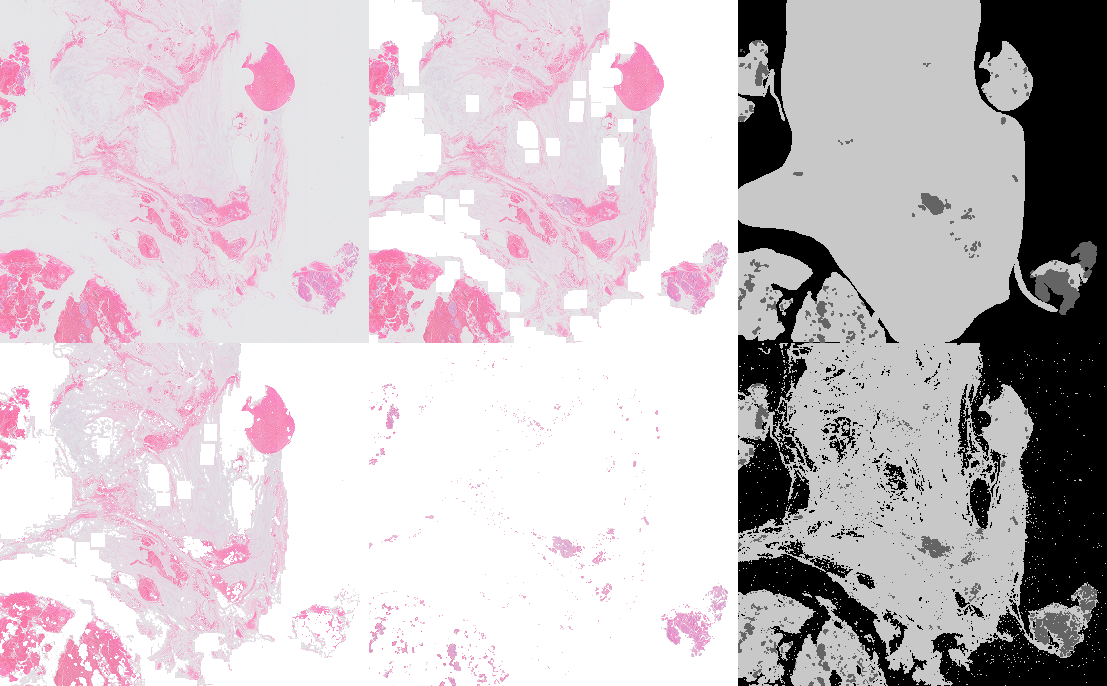

In [153]:
Image.open(sub_exp_root5 / "0_cd.png")

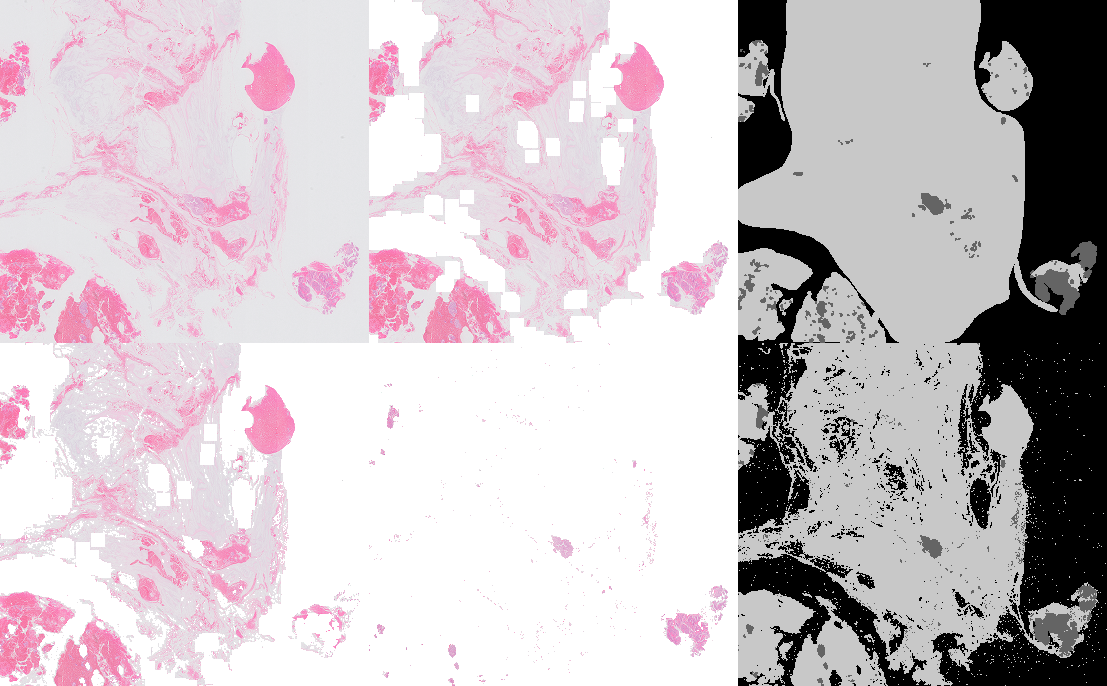

In [154]:
Image.open(sub_exp_root3 / "0_cd.png")

0 of 6
1 of 6
2 of 6
3 of 6
4 of 6
5 of 6


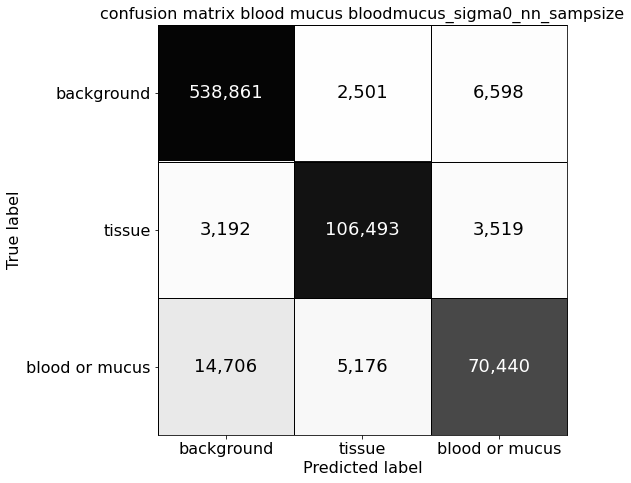

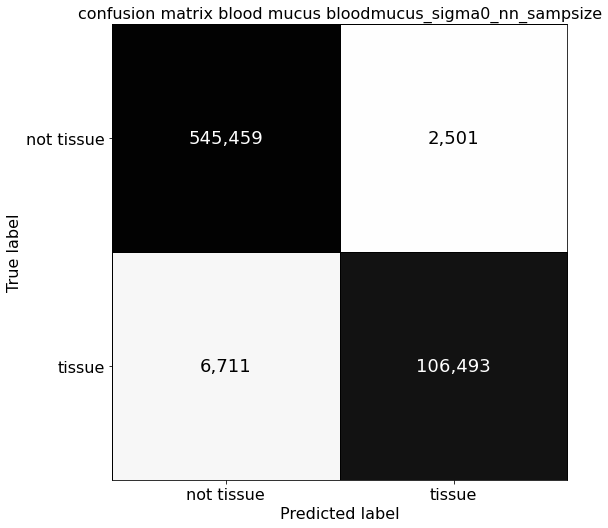

In [176]:
sub_exp_root6 = experiment_root / "mask_cols_morph"
sub_exp_root6.mkdir(parents=True, exist_ok=True)

features_list = [TextureFeature()]
pixel_feature_detector2 = PixelFeatureDetector(features_list=features_list, sigma_min = 1, sigma_max = 2, raw=True)

predict_images2(clf6, sub_exp_root6, pixel_feature_detector2, morph=True)

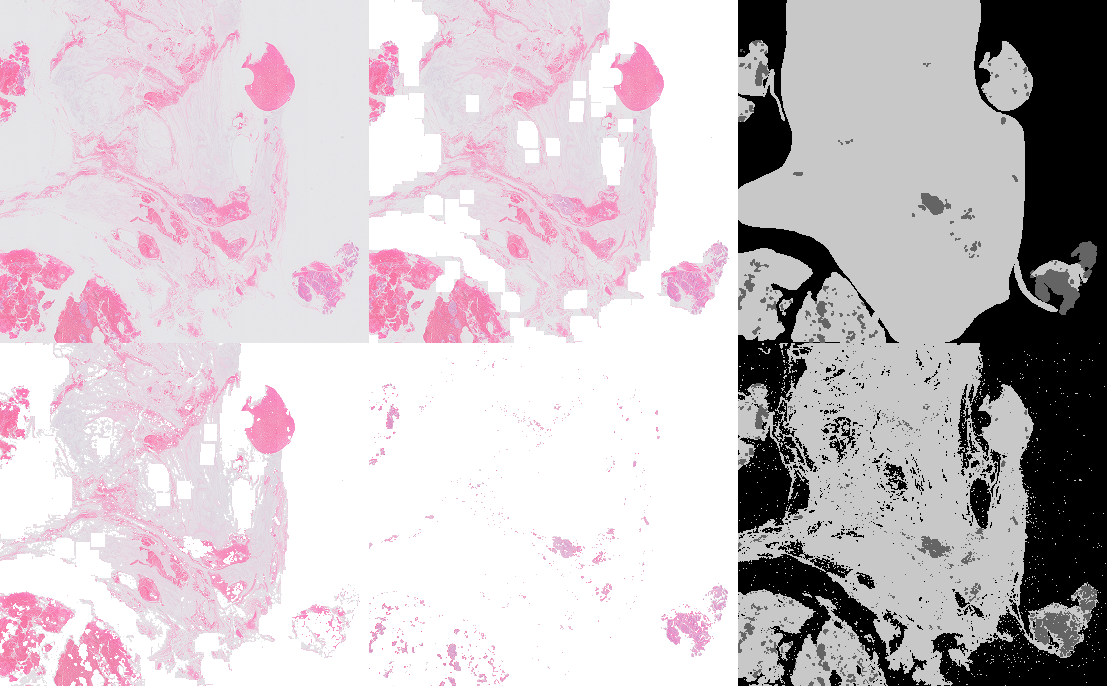

In [156]:
Image.open(sub_exp_root6 / "0_cd.png")

In [160]:
channels = ["r", "g", "b"]
channels = np.repeat(channels, 24)
sigmas = [0,1,2,4,8,16]
sigmas = np.repeat(sigmas, 4)
sigmas = np.tile(sigmas, 3)
feats = ["gauss", "edge", "texture1", "texture2"]
feats = np.tile(feats, 6*3)
feat_mask = np.logical_not(feats == "edge")
small_sigma_mask = sigmas < 2
cols_to_keep_mask = np.logical_and(feat_mask, small_sigma_mask)
cols_to_keep_mask

array([ True, False,  True,  True,  True, False,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False,  True,
        True,  True, False,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False,  True,  True,  True, False,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False])

In [161]:
feats_sample_masked = feats_sample[:, cols_to_keep_mask]
feats_sample_masked.shape

(400000, 18)

In [163]:
clf7 = RandomForestClassifier(n_estimators=50, n_jobs=-1, max_depth=10, max_samples=0.25)
clf7.fit(feats_sample_masked, label_sample.ravel())

RandomForestClassifier(max_depth=10, max_samples=0.25, n_estimators=50,
                       n_jobs=-1)

In [168]:
features_reshape_masked = features_reshape[:, cols_to_keep_mask]
output7 = clf7.predict(features_reshape_masked)
output_probs7 = clf7.predict_proba(features_reshape_masked)

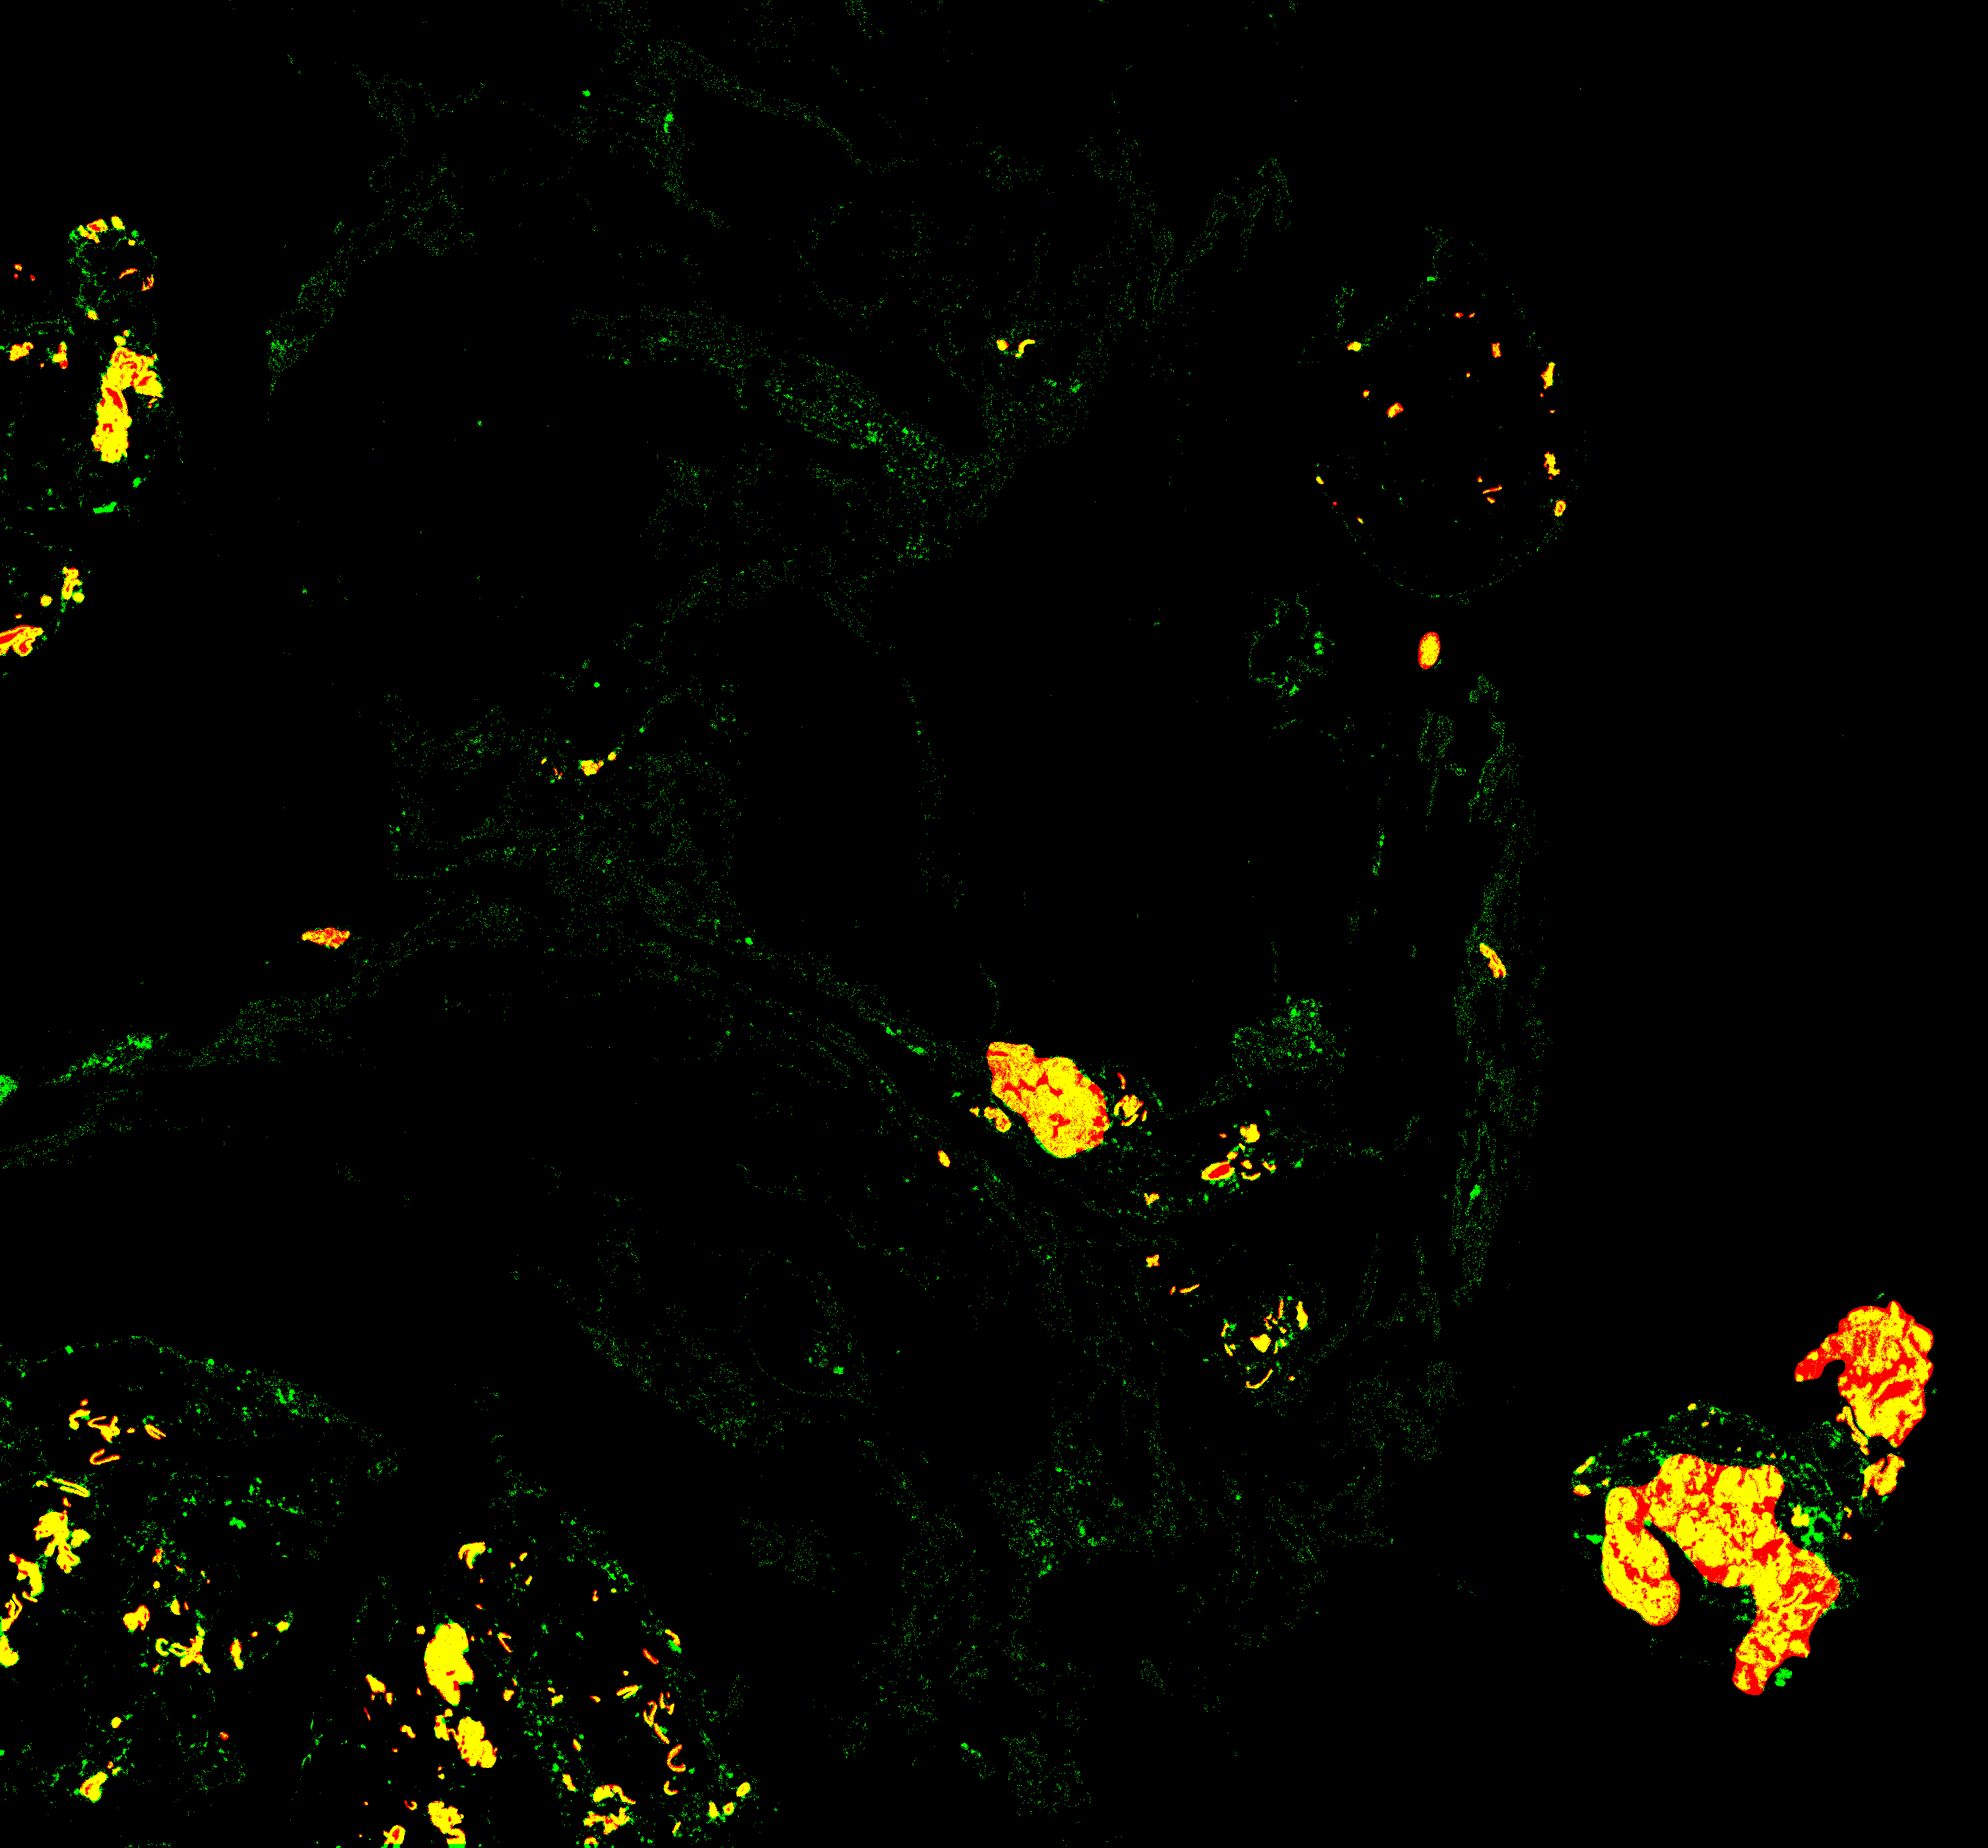

In [169]:
# reshape back to thumb shape
probs_image_comp = np.reshape(output_probs7[:, 0], (thumb.shape[:-1]))
# use tissue detector to set background values to zero
filtered_probs_image_comp = np.where(np.logical_not(tissue_mask), 0, probs_image_comp)
cd_fil_prob_im_comp = filtered_probs_image_comp[minrwf:maxrwf, minclf:maxclf]
comp_img = np.dstack((tissue_annot, cd_fil_prob_im_comp>0.25, np.zeros(tissue_annot.shape)))
Image.fromarray(np.array(comp_img*255, dtype=np.uint8))

0 of 6
1 of 6
2 of 6
3 of 6
4 of 6
5 of 6


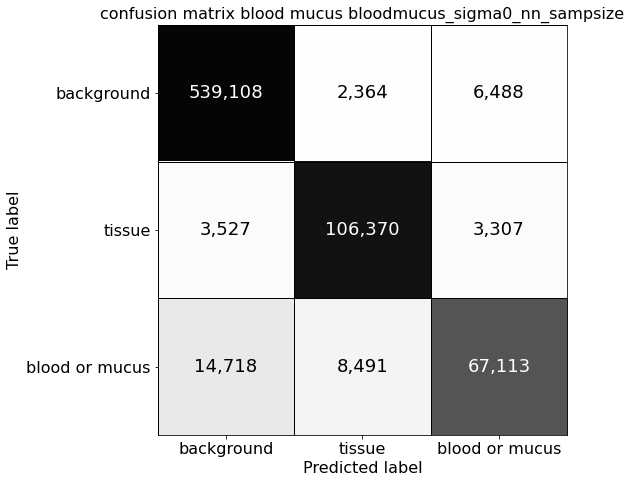

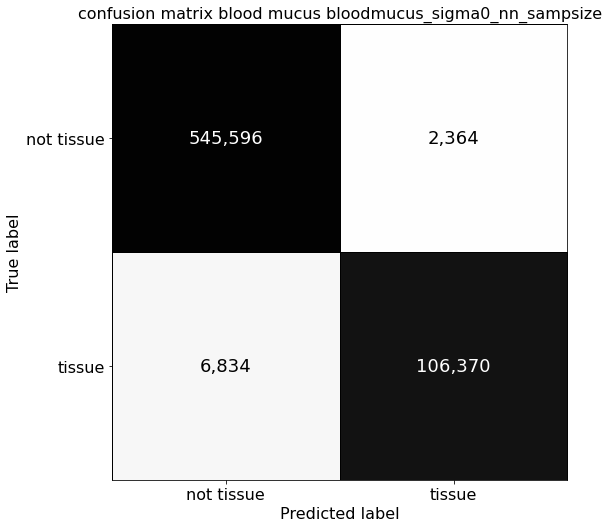

In [172]:
sub_exp_root7 = experiment_root / "only_two_sigmas"
sub_exp_root7.mkdir(parents=True, exist_ok=True)

features_list = [TextureFeature()]
pixel_feature_detector3 = PixelFeatureDetector(features_list=features_list, sigma_min = 1, sigma_max = 1, raw=True)

predict_images2(clf7, sub_exp_root7, pixel_feature_detector3)

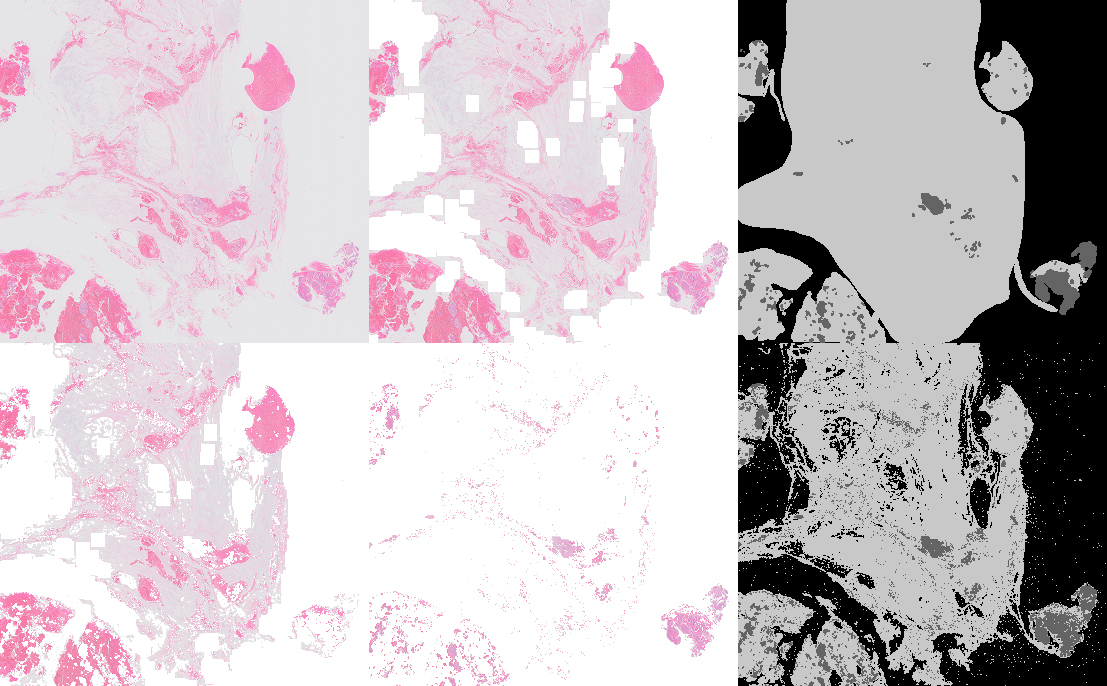

In [173]:
Image.open(sub_exp_root7 / "0_cd.png")

In [174]:
dump(clf6, sub_exp_root6 / 'nn.joblib')
dump(clf7, sub_exp_root7 / 'nn.joblib')

['/home/ubuntu/repath/experiments/bloodmucus_sigma0_nn_sampsize/only_two_sigmas/nn.joblib']